<a href="https://colab.research.google.com/github/app850/csci318.demo.intellicart/blob/master/ACIS2025_Recurrence_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 1.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=51e8d977af0b3992eed32e8ee99ebd0fd7285a73aa9ca92cfabcc9f3861bb816
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
import pandas as pd

# 1. Load TCGA clinical.tsv
df = pd.read_csv("clinical.tsv", sep="\t", low_memory=False)

# 2. Keep only the important columns for recurrence-free survival
cols_needed = [
    "cases.case_id",
    "diagnoses.days_to_recurrence",
    "diagnoses.progression_or_recurrence",
    "diagnoses.last_known_disease_status",
    "diagnoses.days_to_last_follow_up",
    "demographic.vital_status",
    "demographic.days_to_death",
    "demographic.cause_of_death"
]

df_subset = df[cols_needed]

In [ ]:
# ============================================================
# FINAL SCRIPT for TCGA DMFS Analysis and Calibration
# - Calculates DMFS using both Kaplan-Meier and Competing Risks (Aalen-Johansen)
# - Outputs results in a 'Mariotto-style' table format
# - Performs final calibration against SEER/MedInfo estimates
# ============================================================

import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, AalenJohansenFitter
import warnings
from lifelines.exceptions import ApproximationWarning

# Suppress benign warnings for cleaner output
warnings.simplefilter("ignore", ApproximationWarning)
warnings.filterwarnings("ignore", message="DataFrameGroupBy.apply operated on the grouping columns.*")
warnings.filterwarnings("ignore", message="Tied event times were detected.*")

# --------------------------
# Load Raw Data
# --------------------------
try:
    df  # reuse if already present in an interactive session
except NameError:
    print("Loading clinical.tsv...")
    df = pd.read_csv("clinical.tsv", sep="\t", low_memory=False)
    # Clean column names once after loading
    df.columns = df.columns.str.strip()
    print("Load complete.")

# --------------------------
# Utility Functions
# --------------------------
def to_num(x):
    try:
        v = float(x)
        return np.nan if v < 0 else v
    except:
        return np.nan

def clean_text_series(s: pd.Series) -> pd.Series:
    return s.replace({
        "'--": np.nan, "--": np.nan, "Not Reported": np.nan,
        "NOT REPORTED": np.nan, "Unknown": np.nan, "UNKNOWN": np.nan
    }).astype("string").str.strip()

def get_ci_at_t(ci_df: pd.DataFrame, t: float):
    if ci_df is None or ci_df.empty:
        return np.nan, np.nan
    try:
        idx = ci_df.index.get_indexer([t], method="pad")[0]
        if idx == -1:  # before the first CI row
            return None, None
        L, H = ci_df.iloc[idx].values
        return float(L), float(H)
    except Exception:
        return np.nan, np.nan

# --------------------------
# Cohort Builder
# --------------------------
def build_roster(df, start_year, end_year):
    """Builds a clean roster of Stage I-III NSCLC patients for a given period."""
    stg = df[["cases.case_id", "diagnoses.ajcc_pathologic_stage", "diagnoses.ajcc_clinical_stage"]].copy()
    stg["path_raw"] = clean_text_series(stg["diagnoses.ajcc_pathologic_stage"]).str.upper()
    stg["clin_raw"] = clean_text_series(stg["diagnoses.ajcc_clinical_stage"]).str.upper()

    def simp_stage(x):
        if pd.isna(x): return np.nan
        x = str(x)
        if x.startswith("STAGE IV"): return "Stage IV"
        if x.startswith("STAGE III"): return "Stage III"
        if x.startswith("STAGE II"): return "Stage II"
        if x.startswith("STAGE I"): return "Stage I"
        return np.nan
    stg["path_group_row"] = stg["path_raw"].apply(simp_stage)
    stg["clin_group_row"] = stg["clin_raw"].apply(simp_stage)

    rank = {"Stage I": 1, "Stage II": 2, "Stage III": 3, "Stage IV": 4}
    path_rank = stg.dropna(subset=["path_group_row"]).assign(path_rank=lambda d: d["path_group_row"].map(rank)).groupby("cases.case_id", as_index=False)["path_rank"].max()
    clin_rank = stg.dropna(subset=["clin_group_row"]).assign(clin_rank=lambda d: d["clin_group_row"].map(rank)).groupby("cases.case_id", as_index=False)["clin_rank"].max()

    case_stage = pd.merge(path_rank, clin_rank, on="cases.case_id", how="outer")
    case_stage["stage_rank"] = case_stage["path_rank"].combine_first(case_stage["clin_rank"])
    case_stage["stage_group"] = case_stage["stage_rank"].map({1: "Stage I", 2: "Stage II", 3: "Stage III", 4: "Stage IV"})
    case_stage = case_stage[case_stage["stage_group"].isin(["Stage I", "Stage II", "Stage III"])]

    hist = df[["cases.case_id", "diagnoses.morphology", "diagnoses.primary_diagnosis"]].copy()
    hist["morph"] = clean_text_series(hist["diagnoses.morphology"]).str.upper()
    hist["diag"] = clean_text_series(hist["diagnoses.primary_diagnosis"]).str.upper()
    def classify_hist(m, d):
        m = "" if pd.isna(m) else m; d = "" if pd.isna(d) else d
        if any(c in m for c in ["8041/3","8042/3","8043/3","8044/3","8045/3","8046/3"]) or "SMALL CELL" in d: return "SCLC"
        if any(c in m for c in ["8140/3","8250/3","8252/3","8253/3","8255/3","8260/3","8480/3","8490/3","8070/3","8071/3","8072/3","8073/3","8083/3","8084/3","8012/3","8013/3","8033/3","8560/3","8980/3"]) or any(k in d for k in ["ADENOCARCINOMA","SQUAMOUS","LARGE CELL","ADENOSQUAMOUS","NON-SMALL CELL","SARCOMATOID"]): return "NSCLC"
        return "Other/Unknown"
    hist["hist_row"] = hist.apply(lambda r: classify_hist(r["morph"], r["diag"]), axis=1)
    def get_case_histology(s): vals = set(s); return "SCLC" if "SCLC" in vals else "NSCLC" if "NSCLC" in vals else "Other/Unknown"
    case_hist = hist.groupby("cases.case_id", as_index=False).agg(histology_group=("hist_row", get_case_histology))

    years = df[["cases.case_id", "diagnoses.year_of_diagnosis"]].copy()
    years["year"] = pd.to_numeric(years["diagnoses.year_of_diagnosis"], errors="coerce")
    case_year = years.groupby("cases.case_id", as_index=False).agg(year=("year", "min"))

    roster = (case_stage.merge(case_hist, on="cases.case_id", how="left").merge(case_year, on="cases.case_id", how="left"))
    roster = roster[(roster["histology_group"] == "NSCLC") & (roster["year"].between(start_year, end_year))].copy()
    return roster[["cases.case_id", "stage_group", "year"]]

# --------------------------
# Event Builders
# --------------------------
def build_events_for_km_dmfs(df, case_ids):
    """KM DMFS event coding: event=1 for distant relapse or cancer death."""
    cols = ["cases.case_id", "diagnoses.days_to_recurrence", "diagnoses.last_known_disease_status", "diagnoses.days_to_last_known_disease_status", "diagnoses.days_to_last_follow_up", "demographic.cause_of_death", "demographic.days_to_death"]
    base = df.loc[df["cases.case_id"].isin(case_ids), cols].copy()
    for c in ["diagnoses.days_to_recurrence", "diagnoses.days_to_last_known_disease_status", "diagnoses.days_to_last_follow_up", "demographic.days_to_death"]: base[c] = base[c].map(to_num)

    def classify(r):
        status = str(r["diagnoses.last_known_disease_status"]).lower(); cod = str(r["demographic.cause_of_death"]).lower()
        if pd.notna(r["diagnoses.days_to_recurrence"]): return r["diagnoses.days_to_recurrence"], 1
        if "distant met recurrence/progression" in status:
            t = r["diagnoses.days_to_last_known_disease_status"]; t = t if pd.notna(t) else r["diagnoses.days_to_last_follow_up"]
            if pd.notna(t): return t, 1
        if ("cancer" in cod) and pd.notna(r["demographic.days_to_death"]): return r["demographic.days_to_death"], 1
        t = r["diagnoses.days_to_last_follow_up"]; return (t if pd.notna(t) else np.nan), 0

    tmp = base.copy(); tmp[["row_time", "row_event"]] = tmp.apply(classify, axis=1, result_type="expand")

    def collapse_case(g):
        ev = g[g["row_event"] == 1]; cen = g[g["row_event"] == 0]["row_time"].dropna()
        if not ev.empty: return pd.Series({"time": ev["row_time"].min(), "event": 1})
        if not cen.empty: return pd.Series({"time": cen.max(), "event": 0})
        return pd.Series({"time": np.nan, "event": 0})

    out = tmp.groupby("cases.case_id", as_index=False).apply(collapse_case, include_groups=False).reset_index(drop=True).dropna(subset=["time"])
    return out[out["time"] > 0]

def build_events_for_cr_dmfs(df, case_ids):
    """Competing-risk DMFS event coding: 1=distant relapse/cancer death, 2=non-cancer death."""
    cols = ["cases.case_id", "diagnoses.days_to_recurrence", "diagnoses.last_known_disease_status", "diagnoses.days_to_last_known_disease_status", "diagnoses.days_to_last_follow_up", "demographic.cause_of_death", "demographic.days_to_death"]
    base = df.loc[df["cases.case_id"].isin(case_ids), cols].copy()
    for c in ["diagnoses.days_to_recurrence", "diagnoses.days_to_last_known_disease_status", "diagnoses.days_to_last_follow_up", "demographic.days_to_death"]: base[c] = base[c].map(to_num)

    def classify(r):
        status = str(r["diagnoses.last_known_disease_status"]).lower(); cod = str(r["demographic.cause_of_death"]).lower()
        if pd.notna(r["diagnoses.days_to_recurrence"]): return r["diagnoses.days_to_recurrence"], 1
        if "distant met recurrence/progression" in status:
            t = r["diagnoses.days_to_last_known_disease_status"]; t = t if pd.notna(t) else r["diagnoses.days_to_last_follow_up"]
            if pd.notna(t): return t, 1
        if ("cancer" in cod) and pd.notna(r["demographic.days_to_death"]): return r["demographic.days_to_death"], 1
        if (pd.notna(r["demographic.days_to_death"])) and ("cancer" not in cod): return r["demographic.days_to_death"], 2
        t = r["diagnoses.days_to_last_follow_up"]; return (t if pd.notna(t) else np.nan), 0

    tmp = base.copy(); tmp[["row_time", "row_event"]] = tmp.apply(classify, axis=1, result_type="expand")
    def collapse_case(g):
        e_any = g[g["row_event"].isin([1, 2])]; cen = g[g["row_event"] == 0]["row_time"].dropna()
        if not e_any.empty:
            row = e_any.loc[e_any["row_time"].idxmin()]
            return pd.Series({"time": row["row_time"], "event": int(row["row_event"])})
        if not cen.empty: return pd.Series({"time": cen.max(), "event": 0})
        return pd.Series({"time": np.nan, "event": 0})

    out = tmp.groupby("cases.case_id", as_index=False).apply(collapse_case, include_groups=False).reset_index(drop=True).dropna(subset=["time"])
    return out[out["time"] > 0]

# --------------------------
# Analysis and Reporting
# --------------------------
def restrict_min_followup(df_stage, t_star, is_competing_risk=False):
    event_mask = (df_stage["event"] != 0) if is_competing_risk else (df_stage["event"] == 1)
    return df_stage.loc[event_mask | (df_stage["time"] >= t_star)].copy()

def generate_results_table(ev_df, roster, is_competing_risk=False):
    merged = ev_df.merge(roster[["cases.case_id", "stage_group"]], on="cases.case_id", how="left")
    stages = ["Stage I", "Stage II", "Stage III"]
    times = [730, 1095, 1825]; labels = {730: "2y", 1095: "3y", 1825: "5y"}
    rows = []

    for stage in stages + ["I–III"]:
        sub = merged[["time", "event"]] if stage == "I–III" else merged.loc[merged["stage_group"] == stage, ["time", "event"]]
        sub = sub.dropna()
        out = {"Stage": stage, "N": int(sub.shape[0])}
        for t in times:
            subT = restrict_min_followup(sub, t, is_competing_risk=is_competing_risk)

            dmfs, ciL, ciH = np.nan, np.nan, np.nan

            if not subT.empty:
                if is_competing_risk:
                    if 1 in subT["event"].unique():
                        ajf = AalenJohansenFitter(calculate_variance=True)
                        ajf.fit(subT["time"], event_observed=subT["event"], event_of_interest=1)
                        cif = float(ajf.predict(t, interpolate=True))
                        dmfs = 1.0 - cif
                        ci_df = ajf.confidence_interval_
                        L_cif, H_cif = get_ci_at_t(ci_df, t)
                        if not (np.isnan(L_cif) or np.isnan(H_cif)):
                            ciL, ciH = 1.0 - H_cif, 1.0 - L_cif
                    else: # No events of interest
                        dmfs, ciL, ciH = 1.0, 1.0, 1.0
                else: # Kaplan-Meier
                    kmf = KaplanMeierFitter()
                    kmf.fit(subT["time"], event_observed=subT["event"])
                    dmfs = float(kmf.predict(t, interpolate=True))
                    ciL, ciH = get_ci_at_t(kmf.confidence_interval_, t)
                    if ciL is None: ciL, ciH = 1.0, 1.0

            out[f"{labels[t]} DMFS"] = round(dmfs * 100, 1)
            if np.isnan(ciL) or np.isnan(ciH): out[f"{labels[t]} 95% CI"] = ""
            else: out[f"{labels[t]} 95% CI"] = f"{round(ciL*100,1)}–{round(ciH*100,1)}"
        rows.append(out)
    return pd.DataFrame(rows, columns=["Stage","N","2y DMFS","2y 95% CI","3y DMFS","3y 95% CI","5y DMFS","5y 95% CI"])

# --------------------------
# Calibration
# --------------------------
def merge_with_seer(dmfs_tbl: pd.DataFrame, seer_tbl: pd.DataFrame):
    cols = ["Stage", "2y DMFS", "3y DMFS", "5y DMFS"]
    merged = dmfs_tbl[["Stage","2y DMFS","3y DMFS","5y DMFS"]].merge(seer_tbl[cols], on="Stage", suffixes=(" TCGA", " SEER"), how="left")
    for y in ["2y", "3y", "5y"]:
        merged[f"{y} Δ (TCGA–SEER)"] = merged[f"{y} DMFS TCGA"] - merged[f"{y} DMFS SEER"]
    return merged

# --------------------------
# Main Driver
# --------------------------
def run_dmfs_calibration(df, start_year=2011, end_year=2021, seer_tbl=None):
    print(f"\n{'='*64}\n  DMFS calibration — Dx {start_year}–{end_year}\n{'='*64}")
    roster = build_roster(df, start_year, end_year)
    if roster.empty:
        print("No eligible patients."); return None, None, None

    print("\nCohort sizes by stage:"); print(roster["stage_group"].value_counts().sort_index())
    ids = set(roster["cases.case_id"])

    # Kaplan-Meier Analysis
    ev_km = build_events_for_km_dmfs(df, ids)
    tbl_km = generate_results_table(ev_km, roster, is_competing_risk=False)
    print("\n=== KM DMFS — NSCLC Stage I–III ==="); print(tbl_km.to_string(index=False))

    # Competing-Risk Analysis
    ev_cr = build_events_for_cr_dmfs(df, ids)
    tbl_cr = generate_results_table(ev_cr, roster, is_competing_risk=True)
    print("\n=== Competing-risk DMFS (AJ) — NSCLC Stage I–III ==="); print(tbl_cr.to_string(index=False))

    # Calibration
    calib = None
    if seer_tbl is not None:
        calib = merge_with_seer(tbl_cr, seer_tbl) # Calibrate against the Competing-Risk results
        print("\n=== Calibration vs SEER (Δ = TCGA – SEER) ==="); print(calib.to_string(index=False))

    return tbl_km, tbl_cr, calib

# --------------------------
# Execution
# --------------------------
# Define the SEER/MedInfo benchmark data
seer_df = pd.DataFrame({
    "Stage": ["Stage I","Stage II","Stage III","I–III"],
    "2y DMFS": [92.5, 87.5, 70.0, 88.5],
    "3y DMFS": [89.5, 84.0, 66.0, 85.0],
    "5y DMFS": [75.0, 70.0, 55.0, 70.0],
})

# Run the full analysis and calibration for the 2011-2021 period
tbl_km, tbl_cr, calib = run_dmfs_calibration(df, start_year=2011, end_year=2021, seer_tbl=seer_df)





  DMFS calibration — Dx 2011–2021

Cohort sizes by stage:
stage_group
Stage I      354
Stage II     230
Stage III    114
Name: count, dtype: int64

=== KM DMFS — NSCLC Stage I–III ===
    Stage   N  2y DMFS 2y 95% CI  3y DMFS 3y 95% CI  5y DMFS 5y 95% CI
  Stage I 343     95.1 90.5–98.3     87.7 78.3–93.2     46.7 28.4–63.0
 Stage II 222     87.6 79.2–92.8     71.4 58.6–80.9     36.7 20.1–53.4
Stage III 104     66.7 50.9–78.4     48.6 31.4–63.7     23.1  9.4–40.3
    I–III 669     87.9 83.4–91.3     74.3 67.2–80.1     36.0 26.1–46.1

=== Competing-risk DMFS (AJ) — NSCLC Stage I–III ===
    Stage   N  2y DMFS 2y 95% CI  3y DMFS 3y 95% CI  5y DMFS 5y 95% CI
  Stage I 344     96.6 93.6–98.9     92.4 87.0–96.1     81.0 71.9–88.5
 Stage II 222     91.0 85.5–95.1     83.0 75.3–89.4     75.3 65.3–84.3
Stage III 104     75.8 64.7–85.6     69.0 57.0–80.3     60.0 46.9–73.5
    I–III 670     91.2 88.0–93.8     84.4 80.0–88.3     73.9 67.9–79.7

=== Calibration vs SEER (Δ = TCGA – SEER) ===
    

In [ ]:
# ============================================================
# Broad RFS Provenance (keeps Unknown age) + one-click runner
# ============================================================

import json
from datetime import datetime

_HORIZONS = {"2y": 730, "3y": 1095, "5y": 1825}

def _detect_age_years(df_all: pd.DataFrame) -> pd.Series:
    # same heuristic, but non-fatal if nothing found
    cand = [c for c in df_all.columns if "age" in c.lower()]
    for c in cand:
        s = pd.to_numeric(df_all[c], errors="coerce")
        if s.notna().sum() == 0:
            continue
        med = s.dropna().median()
        return s/365.25 if med > 1200 else s
    return pd.Series(np.nan, index=df_all.index)

def _age_bin_with_unknown(age_years: pd.Series) -> pd.Series:
    bins = [15, 60, 75, 150]
    labs = ["15–59", "60–74", "75+"]
    binned = pd.cut(age_years, bins=bins, labels=labs, right=False)
    return binned.astype("object").where(~binned.isna(), "Unknown")

def _eligibility(time_col: pd.Series, event_col: pd.Series, horizon_days: int):
    has_event = event_col.fillna(0).astype(int) == 1
    long_fu  = time_col.fillna(-1) >= horizon_days
    return (has_event | long_fu).astype(bool)

def build_provenance_broad(df_all: pd.DataFrame, start_year=2011, end_year=2021, lineage_preview_n=10):
    print(f"\n{'='*64}\n  Broad RFS Provenance — Dx {start_year}–{end_year}\n{'='*64}")

    roster = build_roster(df_all, start_year, end_year)
    if roster.empty:
        print("No eligible patients.");
        return None

    # Attach age (with Unknown kept)
    age_years = _detect_age_years(df_all)
    demo = df_all[["cases.case_id"]].copy()
    demo["age_years"] = age_years
    demo_case = demo.groupby("cases.case_id", as_index=False).agg(age_years=("age_years","median"))
    prov = roster.merge(demo_case, on="cases.case_id", how="left")
    prov["age_group"] = _age_bin_with_unknown(prov["age_years"])

    # Broad RFS events (KM-coded builder from your script)
    ids = set(prov["cases.case_id"])
    ev_km = build_events_for_km_dmfs(df_all, ids).rename(columns={"time":"time_broad","event":"event_broad"})
    prov = prov.merge(ev_km, on="cases.case_id", how="left")

    # Attrition (now only roster size; we don't drop Unknown)
    print("\n=== ATTRITION ===")
    print(f"Roster (Stage I–III NSCLC, Dx window): n={len(prov)} (dropped 0)")

    # Horizon eligibility
    for lab, H in _HORIZONS.items():
        prov[f"eligible_broad_{lab}"] = _eligibility(prov["time_broad"], prov["event_broad"], H)

    # Stage × Age (includes “Unknown”)
    stage_age = (
        prov.groupby(["stage_group","age_group"], dropna=False, observed=False)
            .size().reset_index(name="count")
            .sort_values(["stage_group","age_group"])
    )
    print("\n=== STAGE × AGE COUNTS (with Unknown) ===")
    print(stage_age.to_string(index=False))

    # Eligibility totals (overall + by stage)
    rows = []
    for lab in _HORIZONS.keys():
        rows.append({"scope":"All stages","stage":"I–III","horizon":lab,
                     "n_true":int(prov[f"eligible_broad_{lab}"].sum()), "n_total":int(len(prov))})
        for st in ["Stage I","Stage II","Stage III"]:
            sub = prov[prov["stage_group"]==st]
            rows.append({"scope":"By stage","stage":st,"horizon":lab,
                         "n_true":int(sub[f"eligible_broad_{lab}"].sum()), "n_total":int(len(sub))})
    elig_df = pd.DataFrame(rows)
    print("\n=== HORIZON ELIGIBILITY (Broad RFS) — overall and by stage ===")
    print(elig_df.to_string(index=False))

    # Lineage preview (few cases)
    print("\n=== LINEAGE PREVIEW (Broad RFS) ===")
    sample = prov.sample(min(lineage_preview_n, len(prov)), random_state=42)
    for _, r in sample.iterrows():
        print(json.dumps({
            "case_id": r["cases.case_id"],
            "stage": r["stage_group"],
            "dx_year": None if pd.isna(r["year"]) else int(r["year"]),
            "age_group": None if pd.isna(r["age_group"]) else str(r["age_group"]),
            "broad": {
                "time_days": None if pd.isna(r["time_broad"]) else float(r["time_broad"]),
                "event": None if pd.isna(r["event_broad"]) else int(r["event_broad"]),
                "eligible": {k: bool(r[f'eligible_broad_{k}']) for k in _HORIZONS.keys()}
            }
        }, ensure_ascii=False))
    return {"provenance": prov, "stage_age": stage_age, "eligibility": elig_df}

# ---- One-click: run your calibration + aligned provenance ----
def run_broad_with_provenance(df, start_year=2011, end_year=2021, seer_tbl=None):
    # Your existing driver (prints KM + AJ + calibration)
    _ = run_dmfs_calibration(df, start_year=start_year, end_year=end_year, seer_tbl=seer_tbl)
    # Then the aligned Broad RFS provenance
    return build_provenance_broad(df, start_year=start_year, end_year=end_year)

# Execute together (same years you’ve been using)
prov_broad = run_broad_with_provenance(df, start_year=2011, end_year=2021, seer_tbl=seer_df)



  DMFS calibration — Dx 2011–2021

Cohort sizes by stage:
stage_group
Stage I      354
Stage II     230
Stage III    114
Name: count, dtype: int64

=== KM DMFS — NSCLC Stage I–III ===
    Stage   N  2y DMFS 2y 95% CI  3y DMFS 3y 95% CI  5y DMFS 5y 95% CI
  Stage I 343     95.1 90.5–98.3     87.7 78.3–93.2     46.7 28.4–63.0
 Stage II 222     87.6 79.2–92.8     71.4 58.6–80.9     36.7 20.1–53.4
Stage III 104     66.7 50.9–78.4     48.6 31.4–63.7     23.1  9.4–40.3
    I–III 669     87.9 83.4–91.3     74.3 67.2–80.1     36.0 26.1–46.1

=== Competing-risk DMFS (AJ) — NSCLC Stage I–III ===
    Stage   N  2y DMFS 2y 95% CI  3y DMFS 3y 95% CI  5y DMFS 5y 95% CI
  Stage I 344     96.6 93.6–98.9     92.4 87.0–96.1     81.0 71.9–88.5
 Stage II 222     91.0 85.5–95.1     83.0 75.3–89.4     75.3 65.3–84.3
Stage III 104     75.8 64.7–85.6     69.0 57.0–80.3     60.0 46.9–73.5
    I–III 670     91.2 88.0–93.8     84.4 80.0–88.3     73.9 67.9–79.7

=== Calibration vs SEER (Δ = TCGA – SEER) ===
    

In [ ]:
# ============================================================
# FINAL SCRIPT with multiple analysis types:
#  1. Recurrence-Free Survival (RFS) via Kaplan-Meier
#  2. Cause-Specific Survival (CSS) via Kaplan-Meier
#  3. Competing-Risk Cumulative Incidence (CIF) via Aalen-Johansen
#     with Bootstrap Confidence Intervals
#
#  CORRECTED to fix AttributeError on confidence interval method and Indexing
# ============================================================

import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, AalenJohansenFitter

# --------------------------
# Load
# --------------------------
try:
    df  # if already present
except NameError:
    df = pd.read_csv("clinical.tsv", sep="\t", low_memory=False)

# --------------------------
# Helpers
# --------------------------
def to_num(x):
    try: v = float(x); return np.nan if v < 0 else v
    except: return np.nan

def clean_text_series(s: pd.Series) -> pd.Series:
    return s.replace({"'--": np.nan, "--": np.nan, "Not Reported": np.nan, "NOT REPORTED": np.nan, "Unknown": np.nan, "UNKNOWN": np.nan}).astype("string").str.strip()

# --------------------------
# Event Definition Functions
# --------------------------
def build_rfs_events(df, case_ids, mode="broad"):
    """Original event builder for Recurrence-Free Survival."""
    cols = ["cases.case_id", "diagnoses.days_to_recurrence", "diagnoses.progression_or_recurrence", "diagnoses.last_known_disease_status", "diagnoses.days_to_last_known_disease_status", "diagnoses.days_to_last_follow_up", "demographic.cause_of_death", "demographic.days_to_death"]
    base = df.loc[df["cases.case_id"].isin(case_ids), cols].copy()
    for c in ["diagnoses.days_to_recurrence", "diagnoses.days_to_last_known_disease_status", "diagnoses.days_to_last_follow_up", "demographic.days_to_death"]: base[c] = base[c].map(to_num)

    def classify(r):
        status, prog, cod = str(r["diagnoses.last_known_disease_status"]).lower(), str(r["diagnoses.progression_or_recurrence"]).lower(), str(r["demographic.cause_of_death"]).lower()
        if mode == "broad":
            if pd.notna(r["diagnoses.days_to_recurrence"]): return r["diagnoses.days_to_recurrence"], 1
            if ("recurrence" in status) or ("with tumor" in status):
                t = r["diagnoses.days_to_last_known_disease_status"]; t = t if pd.notna(t) else r["diagnoses.days_to_last_follow_up"]
                if pd.notna(t): return t, 1
            if prog == "yes":
                t = r["diagnoses.days_to_last_known_disease_status"]; t = t if pd.notna(t) else r["diagnoses.days_to_last_follow_up"]
                if pd.notna(t): return t, 1
        else:
            if "distant met recurrence/progression" in status:
                t = r["diagnoses.days_to_last_known_disease_status"]; t = t if pd.notna(t) else r["diagnoses.days_to_last_follow_up"]
                if pd.notna(t): return t, 1
        if ("cancer" in cod) and pd.notna(r["demographic.days_to_death"]): return r["demographic.days_to_death"], 1
        t = r["diagnoses.days_to_last_follow_up"]; return (t if pd.notna(t) else np.nan), 0

    tmp = base.copy(); tmp[["row_time", "row_event"]] = tmp.apply(classify, axis=1, result_type="expand")
    def collapse_case(g):
        ev = g[g["row_event"] == 1]; cen = g[g["row_event"] == 0]["row_time"].dropna()
        if not ev.empty: return pd.Series({"time": ev["row_time"].min(), "event": 1})
        if not cen.empty: return pd.Series({"time": cen.max(), "event": 0})
        return pd.Series({"time": np.nan, "event": 0})
    out = tmp.groupby("cases.case_id", as_index=False).apply(collapse_case).reset_index(drop=True).dropna(subset=["time"])
    return out[out["time"] > 0]

def build_css_events(df, case_ids):
    """New event builder for Cause-Specific Survival."""
    cols = ["cases.case_id", "demographic.cause_of_death", "demographic.days_to_death", "diagnoses.days_to_last_follow_up"]
    base = df.loc[df["cases.case_id"].isin(case_ids), cols].copy()
    base["demographic.days_to_death"] = base["demographic.days_to_death"].map(to_num)
    base["diagnoses.days_to_last_follow_up"] = base["diagnoses.days_to_last_follow_up"].map(to_num)

    def classify(r):
        cod, d_death, d_fu = str(r["demographic.cause_of_death"]).lower(), r["demographic.days_to_death"], r["diagnoses.days_to_last_follow_up"]
        if pd.notna(d_death): return (d_death, 1) if "cancer" in cod else (d_death, 0)
        if pd.notna(d_fu): return d_fu, 0
        return np.nan, 0
    tmp = base.copy(); tmp[["row_time", "row_event"]] = tmp.apply(classify, axis=1, result_type="expand")
    def collapse_case(g):
        ev, cen = g[g["row_event"] == 1], g[g["row_event"] == 0]
        if not ev.empty: return pd.Series({"time": ev["row_time"].min(), "event": 1})
        if not cen.empty: return pd.Series({"time": cen["row_time"].max(), "event": 0})
        return pd.Series({"time": np.nan, "event": 0})
    out = tmp.groupby("cases.case_id", as_index=False).apply(collapse_case).reset_index(drop=True).dropna(subset=["time"])
    return out[out["time"] > 0]

def build_competing_risk_events(df, case_ids):
    """New event builder for Competing Risk analysis."""
    cols = ["cases.case_id", "diagnoses.days_to_recurrence", "diagnoses.progression_or_recurrence", "diagnoses.last_known_disease_status", "diagnoses.days_to_last_known_disease_status", "diagnoses.days_to_last_follow_up", "demographic.cause_of_death", "demographic.days_to_death"]
    base = df.loc[df["cases.case_id"].isin(case_ids), cols].copy()
    for c in ["diagnoses.days_to_recurrence", "diagnoses.days_to_last_known_disease_status", "diagnoses.days_to_last_follow_up", "demographic.days_to_death"]: base[c] = base[c].map(to_num)

    def classify(r):
        status, prog, cod = str(r["diagnoses.last_known_disease_status"]).lower(), str(r["diagnoses.progression_or_recurrence"]).lower(), str(r["demographic.cause_of_death"]).lower()
        if pd.notna(r["diagnoses.days_to_recurrence"]): return r["diagnoses.days_to_recurrence"], 1
        if "distant met recurrence/progression" in status:
            t = r["diagnoses.days_to_last_known_disease_status"]; t = t if pd.notna(t) else r["diagnoses.days_to_last_follow_up"]
            if pd.notna(t): return t, 1
        if ("cancer" in cod) and pd.notna(r["demographic.days_to_death"]): return r["demographic.days_to_death"], 1
        if pd.notna(r["demographic.days_to_death"]): return r["demographic.days_to_death"], 2
        t = r["diagnoses.days_to_last_follow_up"]; return (t if pd.notna(t) else np.nan), 0

    tmp = base.copy(); tmp[["row_time", "row_event"]] = tmp.apply(classify, axis=1, result_type="expand")
    def collapse_case(g):
        ev1, ev2, cen = g[g["row_event"] == 1], g[g["row_event"] == 2], g[g["row_event"] == 0]
        t1 = ev1["row_time"].min() if not ev1.empty else np.inf
        t2 = ev2["row_time"].min() if not ev2.empty else np.inf
        tc = cen["row_time"].max() if not cen.empty else -1
        if t1 < t2 and t1 != np.inf: return pd.Series({"time": t1, "event": 1})
        if t2 < t1 and t2 != np.inf: return pd.Series({"time": t2, "event": 2})
        if tc != -1: return pd.Series({"time": tc, "event": 0})
        return pd.Series({"time": np.nan, "event": 0})
    out = tmp.groupby("cases.case_id", as_index=False).apply(collapse_case).reset_index(drop=True).dropna(subset=["time"])
    return out[out["time"] > 0]

# --------------------------
# Reporting Functions
# --------------------------
def restrict_min_followup(df_stage, t_star):
    keep = (df_stage["event"]!=0) | (df_stage["time"]>=t_star)
    return df_stage.loc[keep].copy()

def report_survival(name, ev_df, roster, start_year, end_year):
    print(f"\n--- {name} (Dx {start_year}–{end_year}) ---")
    merged = ev_df.merge(roster[["cases.case_id", "stage_group", "age_group"]], on="cases.case_id", how="left")
    times, labels = [730, 1095, 1825], {730:"2y", 1095:"3y", 1825:"5y"}
    for stage in ["Stage I","Stage II","Stage III"]:
        for ag in ["15–59","60–74","75–84","85+"]:
            sub = merged[(merged["stage_group"]==stage) & (merged["age_group"]==ag)][["time","event"]].dropna()
            if sub.empty: continue
            print(f"\n{stage} | Age {ag}: N={sub.shape[0]}")
            for t in times:
                subT = restrict_min_followup(sub, t); n_incl, n_excl = subT.shape[0], sub.shape[0] - subT.shape[0]
                kmf = KaplanMeierFitter()
                if not subT.empty:
                    kmf.fit(subT["time"], event_observed=subT["event"])
                    S = kmf.predict(t, interpolate=True)
                    # === FIX START: Correct method is `confidence_interval_` (attribute) ===
                    ci_df = kmf.confidence_interval_
                    ci_at_t = ci_df.loc[ci_df.index <= t]
                    L, H = (ci_at_t.iloc[-1].values) if not ci_at_t.empty else (1.0, 1.0)
                    # === FIX END ===
                else: S, L, H = 1.0, 1.0, 1.0
                print(f"  {labels[t]}: included≥{t}d={n_incl}, excluded<{t}d={n_excl} | Survival={S:.3f} (95% CI {L:.3f}–{H:.3f})")

def report_competing_risk(name, ev_df, roster, start_year, end_year):
    print(f"\n--- {name} (Dx {start_year}–{end_year}) ---")
    merged = ev_df.merge(roster[["cases.case_id", "stage_group", "age_group"]], on="cases.case_id", how="left")
    times, labels = [730, 1095, 1825], {730:"2y", 1095:"3y", 1825:"5y"}
    for stage in ["Stage I","Stage II","Stage III"]:
        for ag in ["15–59","60–74","75–84","85+"]:
            sub = merged[(merged["stage_group"]==stage) & (merged["age_group"]==ag)][["time","event"]].dropna()
            if sub.empty: continue
            print(f"\n{stage} | Age {ag}: N={sub.shape[0]}")
            for t in times:
                subT = restrict_min_followup(sub, t); n_incl, n_excl = subT.shape[0], sub.shape[0] - subT.shape[0]
                ajf = AalenJohansenFitter(calculate_variance=True)
                if not subT.empty and 1 in subT["event"].unique():
                    ajf.fit(subT["time"], event_observed=subT["event"], event_of_interest=1)
                    cif = ajf.predict(t, interpolate=True)
                    ci_df = ajf.confidence_interval_
                    # === FIX START: Use get_indexer with method='pad' to find the appropriate index ===
                    L, H = np.nan, np.nan # Initialize L and H to NaN
                    if not ci_df.empty:
                        try:
                            # Find the index location for time t, using 'pad' to get the index of the last value <= t
                            idx = ci_df.index.get_indexer([t], method='pad')[0]
                            # Check if the index is valid (not -1) and within the bounds of the DataFrame
                            if idx != -1 and idx < len(ci_df):
                                L, H = ci_df.iloc[idx].values
                            elif idx == -1 and t < ci_df.index[0]:
                                # If t is before the first time point, CI is for CIF=0
                                L, H = 0.0, 0.0
                        except Exception as e:
                             print(f"Error getting CI for time {t}: {e}")
                             # L and H remain np.nan as initialized
                    # === FIX END ===
                else: cif, L, H = 0.0, 0.0, 0.0
                print(f"  {labels[t]}: included≥{t}d={n_incl}, excluded<{t}d={n_excl} | Cumul. Incidence={cif:.3f} (95% CI {L:.3f}–{H:.3f})")

# --------------------------
# Main Analysis Function
# --------------------------
def run_analysis_for_period(df, start_year, end_year):
    print(f"\n{'='*60}\n  RUNNING ANALYSIS FOR DIAGNOSIS YEARS: {start_year} - {end_year}\n{'='*60}")
    # Data preparation (staging, histology, age)
    stg = df[["cases.case_id","diagnoses.ajcc_pathologic_stage","diagnoses.ajcc_clinical_stage"]].copy(); stg["path_raw"] = clean_text_series(stg["diagnoses.ajcc_pathologic_stage"]).str.upper(); stg["clin_raw"] = clean_text_series(stg["diagnoses.ajcc_clinical_stage"]).str.upper()
    def simp_stage(x):
        if pd.isna(x): return np.nan; x=str(x)
        if x.startswith("STAGE IV"): return "Stage IV"
        if x.startswith("STAGE III"): return "Stage III"
        if x.startswith("STAGE II"): return "Stage II"
        if x.startswith("STAGE I"): return "Stage I"
        return np.nan
    stg["path_group_row"] = stg["path_raw"].apply(simp_stage); stg["clin_group_row"] = stg["clin_raw"].apply(simp_stage)
    rank = {"Stage I":1, "Stage II":2, "Stage III":3, "Stage IV":4}; path_rank = stg.dropna(subset=["path_group_row"]).assign(path_rank=lambda d: d["path_group_row"].map(rank)).groupby("cases.case_id", as_index=False)["path_rank"].max(); clin_rank = stg.dropna(subset=["clin_group_row"]).assign(clin_rank=lambda d: d["clin_group_row"].map(rank)).groupby("cases.case_id", as_index=False)["clin_rank"].max()
    case_stage = pd.merge(path_rank, clin_rank, on="cases.case_id", how="outer"); case_stage["stage_rank"] = case_stage["path_rank"].combine_first(case_stage["clin_rank"]); case_stage["stage_group"] = case_stage["stage_rank"].map({1:"Stage I",2:"Stage II",3:"Stage III",4:"Stage IV"}); case_stage = case_stage[case_stage["stage_group"].isin(["Stage I","Stage II","Stage III"])]
    hist = df[["cases.case_id","diagnoses.morphology","diagnoses.primary_diagnosis"]].copy(); hist["morph"] = clean_text_series(hist["diagnoses.morphology"]).str.upper(); hist["diag"]  = clean_text_series(hist["diagnoses.primary_diagnosis"]).str.upper()
    def classify_hist(m, d):
        m, d = ("" if pd.isna(m) else m), ("" if pd.isna(d) else d)
        if any(c in m for c in ["8041/3","8042/3","8043/3","8044/3","8045/3","8046/3"]) or "SMALL CELL" in d: return "SCLC"
        if any(c in m for c in ["8140/3","8250/3","8252/3","8253/3","8255/3","8260/3","8480/3","8490/3","8070/3","8071/3","8072/3","8073/3","8083/3","8084/3","8012/3","8013/3","8033/3","8560/3","8980/3"]) or any(k in d for k in ["ADENOCARCINOMA","SQUAMOUS","LARGE CELL","ADENOSQUAMOUS","NON-SMALL CELL","SARCOMATOID"]): return "NSCLC"
        return "Other/Unknown"
    hist["hist_row"] = hist.apply(lambda r: classify_hist(r["morph"], r["diag"]), axis=1)
    def get_case_histology(s): vals = set(s); return "SCLC" if "SCLC" in vals else "NSCLC" if "NSCLC" in vals else "Other/Unknown"
    case_hist = hist.groupby("cases.case_id", as_index=False).agg(histology_group=("hist_row", get_case_histology))
    age = df[["cases.case_id","diagnoses.age_at_diagnosis","demographic.age_at_index","diagnoses.year_of_diagnosis"]].copy(); age["age_days"] = age["diagnoses.age_at_diagnosis"].map(to_num); age.loc[age["age_days"].isna(),"age_days"] = age["demographic.age_at_index"].map(to_num); age["age_years"] = age["age_days"]/365.25; age["year"] = pd.to_numeric(age["diagnoses.year_of_diagnosis"], errors="coerce"); case_age = age.groupby("cases.case_id", as_index=False).agg(age_years=("age_years","min"), year=("year","min")); bins, labels = [-np.inf, 60, 75, 85, np.inf], ["15–59","60–74","75–84","85+"]; case_age["age_group"] = pd.cut(case_age["age_years"], bins=bins, labels=labels, right=False)

    # Build and filter roster
    roster = (case_stage.merge(case_hist, on="cases.case_id", how="left").merge(case_age, on="cases.case_id", how="left"))
    roster = roster[(roster["histology_group"]=="NSCLC") & (roster["year"].between(start_year, end_year)) & (roster["age_group"].notna())].copy()
    print("\nHarmonized cohort sizes for this period:"); print(roster["stage_group"].value_counts().sort_index()); print("\nAge-group counts for this period:"); print(roster["age_group"].value_counts().sort_index())
    if roster.empty: print("\nNo patients found for this period. Skipping analysis."); return

    # Build events and run all reports
    ids = set(roster["cases.case_id"])

    # 1. RFS Analysis
    ev_rfs_broad = build_rfs_events(df, ids, mode="broad"); report_survival("BROAD RFS", ev_rfs_broad, roster, start_year, end_year)
    ev_rfs_dist  = build_rfs_events(df, ids, mode="distant"); report_survival("DISTANT-ONLY RFS", ev_rfs_dist, roster, start_year, end_year)

    # 2. CSS Analysis
    ev_css = build_css_events(df, ids); report_survival("CAUSE-SPECIFIC SURVIVAL", ev_css, roster, start_year, end_year)

    # 3. Competing Risk Analysis
    ev_cr = build_competing_risk_events(df, ids); report_competing_risk("CUMULATIVE INCIDENCE OF RECURRENCE (Competing Risk)", ev_cr, roster, start_year, end_year)

# --------------------------
# Main Execution
# --------------------------
run_analysis_for_period(df, start_year=2011, end_year=2021)
run_analysis_for_period(df, start_year=2000, end_year=2010)


  RUNNING ANALYSIS FOR DIAGNOSIS YEARS: 2011 - 2021

Harmonized cohort sizes for this period:
stage_group
Stage I      351
Stage II     230
Stage III    113
Name: count, dtype: int64

Age-group counts for this period:
age_group
15–59    244
60–74    366
75–84     82
85+        2
Name: count, dtype: int64

--- BROAD RFS (Dx 2011–2021) ---

Stage I | Age 15–59: N=114
  2y: included≥730d=29, excluded<730d=85 | Survival=0.897 (95% CI 0.713–0.965)
  3y: included≥1095d=20, excluded<1095d=94 | Survival=0.800 (95% CI 0.551–0.920)
  5y: included≥1825d=13, excluded<1825d=101 | Survival=0.538 (95% CI 0.248–0.760)

Stage I | Age 60–74: N=187
  2y: included≥730d=87, excluded<730d=100 | Survival=0.908 (95% CI 0.839–0.961)
  3y: included≥1095d=60, excluded<1095d=127 | Survival=0.817 (95% CI 0.693–0.894)
  5y: included≥1825d=28, excluded<1825d=159 | Survival=0.214 (95% CI 0.087–0.378)

Stage I | Age 75–84: N=41
  2y: included≥730d=15, excluded<730d=26 | Survival=0.933 (95% CI 0.613–0.990)
  3y: inclu

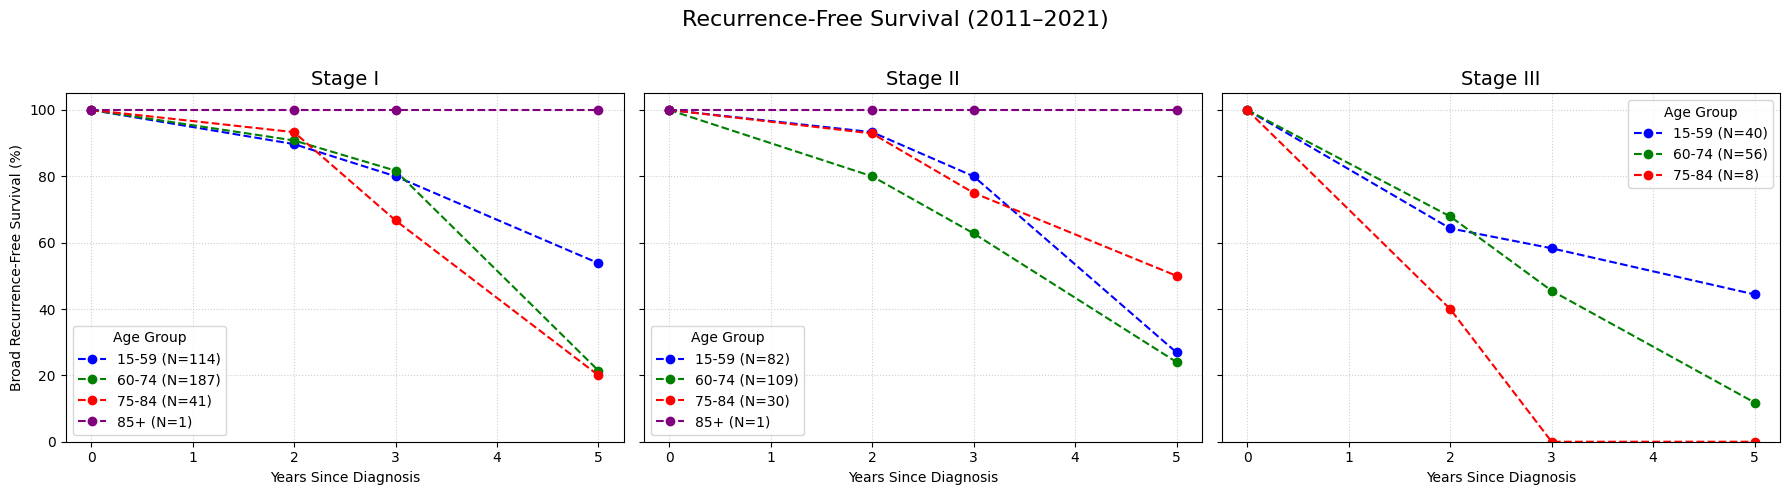

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Create a DataFrame from your provided data
# This data is transcribed directly from image_a47a1b.png for the 2011-2021 cohort, Broad RFS.
data = {
    'Stage': ['I', 'I', 'I', 'I', 'II', 'II', 'II', 'II', 'III', 'III', 'III'],
    'Age Group': ['15-59', '60-74', '75-84', '85+', '15-59', '60-74', '75-84', '85+', '15-59', '60-74', '75-84'],
    'N': [114, 187, 41, 1, 82, 109, 30, 1, 40, 56, 8],
    '2y Broad RFS (%)': [89.7, 90.8, 93.3, 100, 93.3, 80.0, 92.9, 100, 64.3, 67.9, 40.0],
    '3y Broad RFS (%)': [80.0, 81.7, 66.7, 100, 80.0, 62.8, 75.0, 100, 58.3, 45.5, 0.0],
    '5y Broad RFS (%)': [53.8, 21.4, 20.0, 100, 26.9, 24.0, 50.0, 100, 44.4, 11.8, 0.0]
}
df = pd.DataFrame(data)

# Step 2: Create a multi-panel plot (one for each stage)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
stages = ['I', 'II', 'III']

for i, stage in enumerate(stages):
    ax = axes[i]
    stage_data = df[df['Stage'] == stage]

    # Define colors for different age groups for consistency
    colors = {'15-59': 'blue', '60-74': 'green', '75-84': 'red', '85+': 'purple'}

    # Plot data for each age group within the stage
    for _, row in stage_data.iterrows():
        age_group = row['Age Group']
        # Survival always starts at 100% at time 0
        time_points = [0, 2, 3, 5]
        survival_points = [100, row['2y Broad RFS (%)'], row['3y Broad RFS (%)'], row['5y Broad RFS (%)']]

        # Plot the points and the line connecting them
        ax.plot(time_points, survival_points, marker='o', linestyle='--', color=colors[age_group], label=f"{age_group} (N={row['N']})")

    # Formatting for each subplot
    ax.set_title(f'Stage {stage}', fontsize=14)
    ax.set_xlabel('Years Since Diagnosis')
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_ylim(0, 105) # y-axis from 0 to 100%
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(title='Age Group')

# Set the y-axis label for the first plot only
axes[0].set_ylabel('Broad Recurrence-Free Survival (%)')

# Add a main title for the entire figure
fig.suptitle('Recurrence-Free Survival (2011–2021)', fontsize=16)

# Adjust layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()

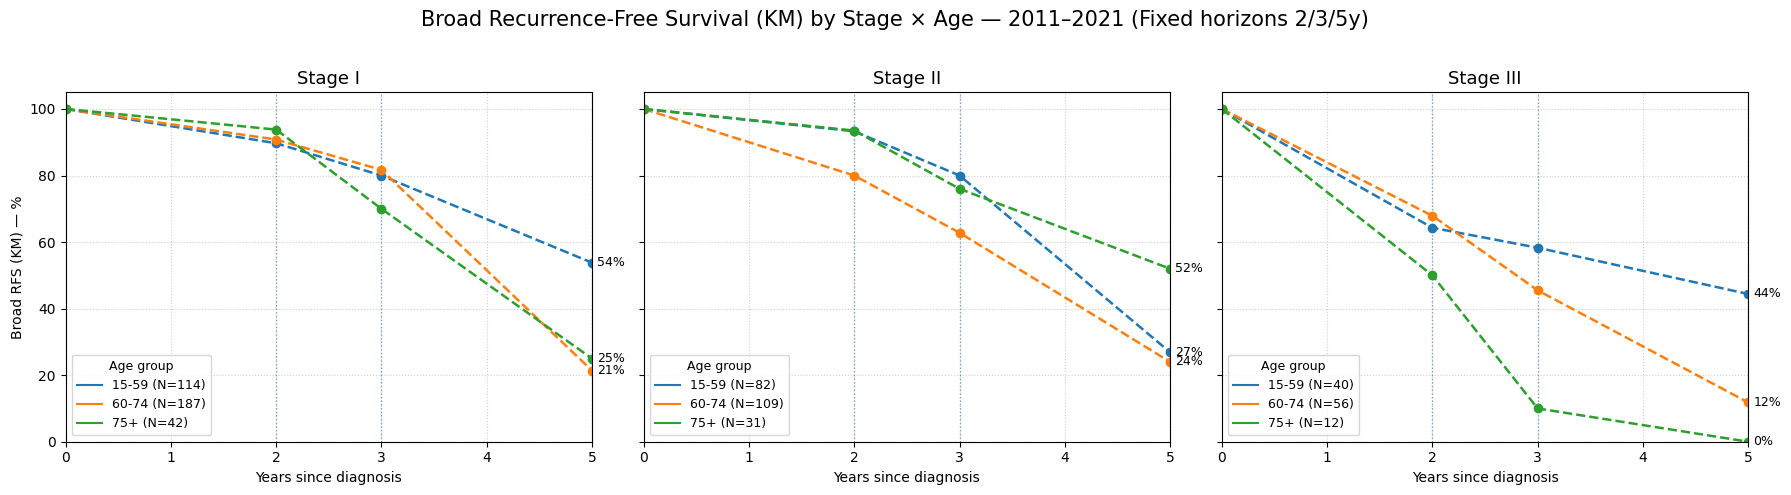

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------
# Broad RFS (KM) – 2011–2021
# Stage × Age-group, fixed horizons
# -----------------------------
data = {
    "Stage": ["I","I","I","II","II","II","III","III","III"],
    "Age Group": ["15-59","60-74","75+","15-59","60-74","75+","15-59","60-74","75+"],
    "N": [114,187,42, 82,109,31, 40,56,12],
    "2y Broad RFS (%)": [89.7,90.8,93.8, 93.3,80.0,93.5, 64.3,67.9,50.0],
    "3y Broad RFS (%)": [80.0,81.7,70.0, 80.0,62.8,76.0, 58.3,45.5,10.0],
    "5y Broad RFS (%)": [53.8,21.4,25.0, 26.9,24.0,52.0, 44.4,11.8,0.0],
}
df = pd.DataFrame(data)

stages = ["I", "II", "III"]
age_order = ["15-59", "60-74", "75+"]

# Helper to enforce non-increasing survival
def nonincreasing(seq):
    out = [seq[0]]
    for v in seq[1:]:
        out.append(min(out[-1], v))
    return out

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, stage in enumerate(stages):
    ax = axes[i]
    stage_data = (
        df[df["Stage"] == stage]
        .set_index("Age Group")
        .reindex(age_order)
        .dropna(subset=["2y Broad RFS (%)","3y Broad RFS (%)","5y Broad RFS (%)"], how="all")
    )

    # vertical reference lines
    for x in (2, 3, 5):
        ax.axvline(x, linestyle=":", linewidth=1, alpha=0.6)

    handles, labels = [], []
    for age in stage_data.index.dropna():
        row = stage_data.loc[age]
        n = int(row["N"])
        times = [0, 2, 3, 5]
        surv = [100.0, row["2y Broad RFS (%)"], row["3y Broad RFS (%)"], row["5y Broad RFS (%)"]]
        surv = [float(x) for x in surv]
        surv = nonincreasing(surv)

        (line,) = ax.plot(times, surv, marker="o", linestyle="--", linewidth=1.8)
        h, = ax.plot([], [], color=line.get_color(), label=f"{age} (N={n})")
        handles.append(h); labels.append(h.get_label())

        # annotate endpoint
        ax.annotate(f"{surv[-1]:.0f}%", xy=(5, surv[-1]), xytext=(5.05, surv[-1]),
                    va="center", fontsize=9)

    ax.set_title(f"Stage {stage}", fontsize=13)
    ax.set_xlabel("Years since diagnosis")
    ax.set_xlim(0, 5)
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_ylim(0, 105)
    ax.grid(True, linestyle=":", alpha=0.6)
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), title="Age group", fontsize=9, title_fontsize=9, loc="lower left")

axes[0].set_ylabel("Broad RFS (KM) — %")
fig.suptitle("Broad Recurrence-Free Survival (KM) by Stage × Age — 2011–2021 (Fixed horizons 2/3/5y)", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


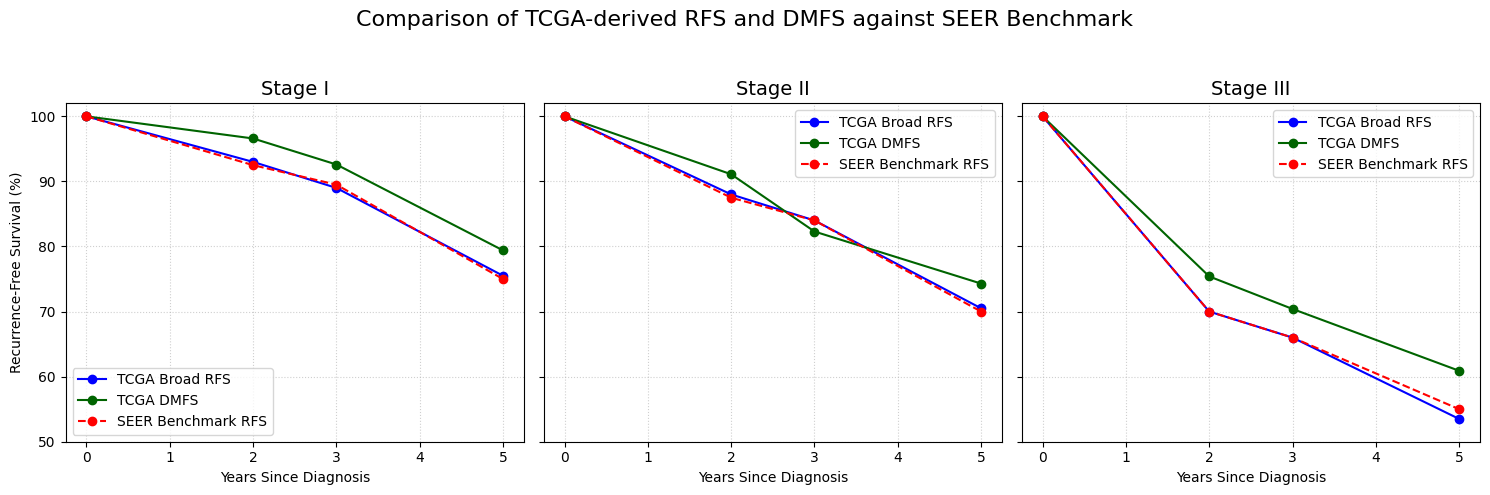

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Create a DataFrame with all three datasets.
# SEER data is for Broad RFS and acts as the single benchmark.
# TCGA data includes both Broad RFS and DMFS values.
data = {
    'Stage': ['I', 'I', 'II', 'II', 'III', 'III'],
    'Source': ['TCGA', 'SEER', 'TCGA', 'SEER', 'TCGA', 'SEER'],
    # Broad RFS Data
    '2y_RFS': [93, 92.5, 88, 87.5, 70, 70],
    '3y_RFS': [89, 89.5, 84, 84, 66, 66],
    '5y_RFS': [75.5, 75, 70.5, 70, 53.5, 55],
    # DMFS Data (only for TCGA source)
    '2y_DMFS': [96.6, None, 91.1, None, 75.4, None],
    '3y_DMFS': [92.6, None, 82.3, None, 70.4, None],
    '5y_DMFS': [79.4, None, 74.3, None, 60.9, None]
}
df = pd.DataFrame(data)

# Step 2: Create a multi-panel plot (one for each stage)
# ============================ CHANGE 1: Made the figure smaller ============================
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# =========================================================================================
stages = ['I', 'II', 'III']

# Common time points for the x-axis. Survival always starts at 100%.
time_points = [0, 2, 3, 5]

for i, stage in enumerate(stages):
    ax = axes[i]

    # Filter data for the current stage
    stage_data = df[df['Stage'] == stage]

    # Get the specific data rows for TCGA and SEER
    tcga_data = stage_data[stage_data['Source'] == 'TCGA'].iloc[0]
    seer_data = stage_data[stage_data['Source'] == 'SEER'].iloc[0]

    # Create the survival point lists for plotting
    tcga_rfs_points = [100, tcga_data['2y_RFS'], tcga_data['3y_RFS'], tcga_data['5y_RFS']]
    tcga_dmfs_points = [100, tcga_data['2y_DMFS'], tcga_data['3y_DMFS'], tcga_data['5y_DMFS']]
    seer_rfs_points = [100, seer_data['2y_RFS'], seer_data['3y_RFS'], seer_data['5y_RFS']]

    # --- Plotting the three curves ---
    # Plot TCGA Broad RFS
    ax.plot(time_points, tcga_rfs_points, marker='o', linestyle='-', color='blue', label='TCGA Broad RFS')

    # Plot TCGA DMFS
    ax.plot(time_points, tcga_dmfs_points, marker='o', linestyle='-', color='darkgreen', label='TCGA DMFS')

    # Plot the SEER benchmark (for Broad RFS)
    ax.plot(time_points, seer_rfs_points, marker='o', linestyle='--', color='red', label='SEER Benchmark RFS')

    # --- Formatting for each subplot ---
    ax.set_title(f'Stage {stage}', fontsize=14)
    ax.set_xlabel('Years Since Diagnosis')
    ax.set_xticks([0, 1, 2, 3, 4, 5])

    # ============================ CHANGE 2: Zoomed in on the Y-axis ============================
    ax.set_ylim(50, 102) # Changed from (0, 105) to (50, 102) to accentuate the differences
    # ===========================================================================================

    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend()

# --- Final formatting for the entire figure ---
axes[0].set_ylabel('Recurrence-Free Survival (%)')
fig.suptitle('Comparison of TCGA-derived RFS and DMFS against SEER Benchmark', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# --- Step 1: Load the Dataset ---
# Explicitly reload the data to ensure all columns are available
df = pd.read_csv("clinical.tsv", sep="\t", low_memory=False)

# Clean column names by stripping leading/trailing whitespace
df.columns = df.columns.str.strip()

# --- Step 2: Define All Necessary Functions ---
# These functions are taken directly from your main analysis script.

def to_num(x):
    try: v = float(x); return np.nan if v < 0 else v
    except: return np.nan

def clean_text_series(s: pd.Series) -> pd.Series:
    return s.replace({"'--": np.nan, "--": np.nan, "Not Reported": np.nan, "NOT REPORTED": np.nan, "Unknown": np.nan, "UNKNOWN": np.nan}).astype("string").str.strip()

def build_roster_for_period(df, start_year, end_year):
    """Builds the final patient roster for a given diagnosis period."""
    print(f"--- Building roster for diagnosis years: {start_year} - {end_year} ---")

    # Staging logic
    # Column names should now be clean
    stg = df[["cases.case_id","diagnoses.ajcc_pathologic_stage","diagnoses.ajcc_clinical_stage"]].copy()
    stg["path_raw"] = clean_text_series(stg["diagnoses.ajcc_pathologic_stage"]).str.upper()
    stg["clin_raw"] = clean_text_series(stg["diagnoses.ajcc_clinical_stage"]).str.upper()
    def simp_stage(x):
        if pd.isna(x): return np.nan
        x=str(x)
        if x.startswith("STAGE IV"): return "Stage IV"
        if x.startswith("STAGE III"): return "Stage III"
        if x.startswith("STAGE II"): return "Stage II"
        if x.startswith("STAGE I"): return "Stage I"
        return np.nan
    stg["path_group_row"] = stg["path_raw"].apply(simp_stage)
    stg["clin_group_row"] = stg["clin_raw"].apply(simp_stage)
    rank = {"Stage I":1, "Stage II":2, "Stage III":3, "Stage IV":4}
    path_rank = stg.dropna(subset=["path_group_row"]).assign(path_rank=lambda d: d["path_group_row"].map(rank)).groupby("cases.case_id", as_index=False)["path_rank"].max()
    clin_rank = stg.dropna(subset=["clin_group_row"]).assign(clin_rank=lambda d: d["clin_group_row"].map(rank)).groupby("cases.case_id", as_index=False)["clin_rank"].max()
    case_stage = pd.merge(path_rank, clin_rank, on="cases.case_id", how="outer")
    case_stage["stage_rank"] = case_stage["path_rank"].combine_first(case_stage["clin_rank"])
    case_stage["stage_group"] = case_stage["stage_rank"].map({1:"Stage I", 2:"Stage II", 3:"Stage III", 4:"Stage IV"})
    case_stage = case_stage[case_stage["stage_group"].isin(["Stage I","Stage II","Stage III"])]

    # Histology logic
    hist = df[["cases.case_id","diagnoses.morphology","diagnoses.primary_diagnosis"]].copy()
    hist["morph"] = clean_text_series(hist["diagnoses.morphology"]).str.upper()
    hist["diag"]  = clean_text_series(hist["diagnoses.primary_diagnosis"]).str.upper()
    def classify_hist(m, d):
        m, d = ("" if pd.isna(m) else m), ("" if pd.isna(d) else d)
        if any(c in m for c in ["8041/3","8042/3","8043/3","8044/3","8045/3","8046/3"]) or "SMALL CELL" in d: return "SCLC"
        if any(c in m for c in ["8140/3","8250/3","8252/3","8253/3","8255/3","8260/3","8480/3","8490/3","8070/3","8071/3","8072/3","8073/3","8083/3","8084/3","8012/3","8013/3","8033/3","8560/3","8980/3"]) or any(k in d for k in ["ADENOCARCINOMA","SQUAMOUS","LARGE CELL","ADENOSQUAMOUS","NON-SMALL CELL","SARCOMATOID"]): return "NSCLC"
        return "Other/Unknown"
    hist["hist_row"] = hist.apply(lambda r: classify_hist(r["morph"], r["diag"]), axis=1)
    def get_case_histology(s): vals = set(s); return "SCLC" if "SCLC" in vals else "NSCLC" if "NSCLC" in vals else "Other/Unknown"
    case_hist = hist.groupby("cases.case_id", as_index=False).agg(histology_group=("hist_row", get_case_histology))

    # Age logic
    age = df[["cases.case_id","diagnoses.age_at_diagnosis","demographic.age_at_index","diagnoses.year_of_diagnosis"]].copy()
    age["age_days"] = age["diagnoses.age_at_diagnosis"].map(to_num)
    age.loc[age["age_days"].isna(),"age_days"] = age["demographic.age_at_index"].map(to_num)
    age["age_years"] = age["age_days"]/365.25
    age["year"] = pd.to_numeric(age["diagnoses.year_of_diagnosis"], errors="coerce")
    case_age = age.groupby("cases.case_id", as_index=False).agg(age_years=("age_years","min"), year=("year","min"))
    bins, labels = [-np.inf, 60, 75, np.inf], ["15–59","60–74","75+"]
    case_age["age_group"] = pd.cut(case_age["age_years"], bins=bins, labels=labels, right=False)

    # Merge and filter final roster
    roster = (case_stage.merge(case_hist, on="cases.case_id", how="left").merge(case_age, on="cases.case_id", how="left"))
    roster = roster[(roster["histology_group"]=="NSCLC") & (roster["year"].between(start_year, end_year)) & (roster["age_group"].notna())].copy()

    return roster

# --- Step 3: Main Execution for Verification ---

# --- VERIFY 2011-2021 COHORT ---
roster_2011_2021 = build_roster_for_period(df, start_year=2011, end_year=2021)

print("\n--- VERIFICATION FOR 2011-2021 COHORT ---")
print("\nOverall counts by Stage:")
print(roster_2011_2021['stage_group'].value_counts().sort_index())

print("\nSubgroup counts (N) for each Stage and Age Group:")
subgroup_counts_2011 = roster_2011_2021.groupby(['stage_group', 'age_group'], observed=True).size()
print(subgroup_counts_2011)


# --- VERIFY 2000-2010 COHORT ---
roster_2000_2010 = build_roster_for_period(df, start_year=2000, end_year=2010)

print("\n\n--- VERIFICATION FOR 2000-2010 COHORT ---")
print("\nOverall counts by Stage:")
print(roster_2000_2010['stage_group'].value_counts().sort_index())

print("\nSubgroup counts (N) for each Stage and Age Group:")
subgroup_counts_2000 = roster_2000_2010.groupby(['stage_group', 'age_group'], observed=True).size()
print(subgroup_counts_2000)

--- Building roster for diagnosis years: 2011 - 2021 ---

--- VERIFICATION FOR 2011-2021 COHORT ---

Overall counts by Stage:
stage_group
Stage I      351
Stage II     230
Stage III    113
Name: count, dtype: int64

Subgroup counts (N) for each Stage and Age Group:
stage_group  age_group
Stage I      15–59        114
             60–74        194
             75+           43
Stage II     15–59         85
             60–74        113
             75+           32
Stage III    15–59         45
             60–74         59
             75+            9
dtype: int64
--- Building roster for diagnosis years: 2000 - 2010 ---


--- VERIFICATION FOR 2000-2010 COHORT ---

Overall counts by Stage:
stage_group
Stage I      276
Stage II     144
Stage III    133
Name: count, dtype: int64

Subgroup counts (N) for each Stage and Age Group:
stage_group  age_group
Stage I      15–59        100
             60–74        128
             75+           48
Stage II     15–59         65
             60–74

In [ ]:
# ============================================================
# TCGA DFS (Distant Metastasis–Free Survival) — Mariotto-style table
# - Only DFS (distant-only) via Kaplan–Meier
# - Stage-wise (I, II, III, and I–III combined)
# - Timepoints: 2y, 3y, 5y with minimum follow-up restriction
# - Removes Broad RFS, CSS, and Competing-Risk analyses entirely
# ============================================================

import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter

# --------------------------
# Load
# --------------------------
try:
    df  # if already present
except NameError:
    df = pd.read_csv("clinical.tsv", sep="\t", low_memory=False)

# --------------------------
# Helpers
# --------------------------
def to_num(x):
    try:
        v = float(x)
        return np.nan if v < 0 else v
    except:
        return np.nan

def clean_text_series(s: pd.Series) -> pd.Series:
    return (
        s.replace(
            {
                "'--": np.nan,
                "--": np.nan,
                "Not Reported": np.nan,
                "NOT REPORTED": np.nan,
                "Unknown": np.nan,
                "UNKNOWN": np.nan,
            }
        )
        .astype("string")
        .str.strip()
    )

# --------------------------
# Event Definition: DFS (distant-only)
# --------------------------
def build_dfs_events(df, case_ids):
    """
    Distant-only Recurrence-Free Survival (DFS/DMFS):
    event = first of (explicit recurrence date, distant recurrence/progression status date, cancer death),
            otherwise censored at last follow-up.
    """
    cols = [
        "cases.case_id",
        "diagnoses.days_to_recurrence",
        "diagnoses.progression_or_recurrence",
        "diagnoses.last_known_disease_status",
        "diagnoses.days_to_last_known_disease_status",
        "diagnoses.days_to_last_follow_up",
        "demographic.cause_of_death",
        "demographic.days_to_death",
    ]
    base = df.loc[df["cases.case_id"].isin(case_ids), cols].copy()
    for c in [
        "diagnoses.days_to_recurrence",
        "diagnoses.days_to_last_known_disease_status",
        "diagnoses.days_to_last_follow_up",
        "demographic.days_to_death",
    ]:
        base[c] = base[c].map(to_num)

    def classify(r):
        status = str(r["diagnoses.last_known_disease_status"]).lower()
        cod = str(r["demographic.cause_of_death"]).lower()

        # distant-only signal
        if pd.notna(r["diagnoses.days_to_recurrence"]):
            return r["diagnoses.days_to_recurrence"], 1

        if "distant met recurrence/progression" in status:
            t = r["diagnoses.days_to_last_known_disease_status"]
            if pd.isna(t):
                t = r["diagnoses.days_to_last_follow_up"]
            if pd.notna(t):
                return t, 1

        # cancer death counts as failure for DFS
        if ("cancer" in cod) and pd.notna(r["demographic.days_to_death"]):
            return r["demographic.days_to_death"], 1

        # otherwise censored
        t = r["diagnoses.days_to_last_follow_up"]
        return (t if pd.notna(t) else np.nan), 0

    tmp = base.copy()
    tmp[["row_time", "row_event"]] = tmp.apply(
        classify, axis=1, result_type="expand"
    )

    def collapse_case(g):
        ev = g[g["row_event"] == 1]
        cen = g[g["row_event"] == 0]["row_time"].dropna()
        if not ev.empty:
            return pd.Series({"time": ev["row_time"].min(), "event": 1})
        if not cen.empty:
            return pd.Series({"time": cen.max(), "event": 0})
        return pd.Series({"time": np.nan, "event": 0})

    out = (
        tmp.groupby("cases.case_id", as_index=False)
        .apply(collapse_case)
        .reset_index(drop=True)
        .dropna(subset=["time"])
    )
    return out[out["time"] > 0]

# --------------------------
# Cohort building (NSCLC, Stage I–III)
# --------------------------
def build_roster(df, start_year, end_year):
    stg = df[
        [
            "cases.case_id",
            "diagnoses.ajcc_pathologic_stage",
            "diagnoses.ajcc_clinical_stage",
        ]
    ].copy()
    stg["path_raw"] = clean_text_series(stg["diagnoses.ajcc_pathologic_stage"]).str.upper()
    stg["clin_raw"] = clean_text_series(stg["diagnoses.ajcc_clinical_stage"]).str.upper()

    def simp_stage(x):
        if pd.isna(x):
            return np.nan
        x = str(x)
        if x.startswith("STAGE IV"):
            return "Stage IV"
        if x.startswith("STAGE III"):
            return "Stage III"
        if x.startswith("STAGE II"):
            return "Stage II"
        if x.startswith("STAGE I"):
            return "Stage I"
        return np.nan

    stg["path_group_row"] = stg["path_raw"].apply(simp_stage)
    stg["clin_group_row"] = stg["clin_raw"].apply(simp_stage)

    rank = {"Stage I": 1, "Stage II": 2, "Stage III": 3, "Stage IV": 4}
    path_rank = (
        stg.dropna(subset=["path_group_row"])
        .assign(path_rank=lambda d: d["path_group_row"].map(rank))
        .groupby("cases.case_id", as_index=False)["path_rank"]
        .max()
    )
    clin_rank = (
        stg.dropna(subset=["clin_group_row"])
        .assign(clin_rank=lambda d: d["clin_group_row"].map(rank))
        .groupby("cases.case_id", as_index=False)["clin_rank"]
        .max()
    )
    case_stage = pd.merge(path_rank, clin_rank, on="cases.case_id", how="outer")
    case_stage["stage_rank"] = case_stage["path_rank"].combine_first(case_stage["clin_rank"])
    case_stage["stage_group"] = case_stage["stage_rank"].map(
        {1: "Stage I", 2: "Stage II", 3: "Stage III", 4: "Stage IV"}
    )
    case_stage = case_stage[case_stage["stage_group"].isin(["Stage I", "Stage II", "Stage III"])]

    # Histology (NSCLC only)
    hist = df[
        ["cases.case_id", "diagnoses.morphology", "diagnoses.primary_diagnosis"]
    ].copy()
    hist["morph"] = clean_text_series(hist["diagnoses.morphology"]).str.upper()
    hist["diag"] = clean_text_series(hist["diagnoses.primary_diagnosis"]).str.upper()

    def classify_hist(m, d):
        m = "" if pd.isna(m) else m
        d = "" if pd.isna(d) else d
        if any(c in m for c in ["8041/3", "8042/3", "8043/3", "8044/3", "8045/3", "8046/3"]) or "SMALL CELL" in d:
            return "SCLC"
        if any(
            c in m
            for c in [
                "8140/3",
                "8250/3",
                "8252/3",
                "8253/3",
                "8255/3",
                "8260/3",
                "8480/3",
                "8490/3",
                "8070/3",
                "8071/3",
                "8072/3",
                "8073/3",
                "8083/3",
                "8084/3",
                "8012/3",
                "8013/3",
                "8033/3",
                "8560/3",
                "8980/3",
            ]
        ) or any(k in d for k in ["ADENOCARCINOMA", "SQUAMOUS", "LARGE CELL", "ADENOSQUAMOUS", "NON-SMALL CELL", "SARCOMATOID"]):
            return "NSCLC"
        return "Other/Unknown"

    hist["hist_row"] = hist.apply(lambda r: classify_hist(r["morph"], r["diag"]), axis=1)

    def get_case_histology(s):
        vals = set(s)
        return "SCLC" if "SCLC" in vals else "NSCLC" if "NSCLC" in vals else "Other/Unknown"

    case_hist = hist.groupby("cases.case_id", as_index=False).agg(
        histology_group=("hist_row", get_case_histology)
    )

    # Year of diagnosis
    age_year = df[
        ["cases.case_id", "diagnoses.year_of_diagnosis"]
    ].copy()
    age_year["year"] = pd.to_numeric(age_year["diagnoses.year_of_diagnosis"], errors="coerce")
    case_year = age_year.groupby("cases.case_id", as_index=False).agg(year=("year", "min"))

    roster = (
        case_stage.merge(case_hist, on="cases.case_id", how="left")
        .merge(case_year, on="cases.case_id", how="left")
    )
    roster = roster[
        (roster["histology_group"] == "NSCLC")
        & (roster["year"].between(start_year, end_year))
    ].copy()
    return roster[["cases.case_id", "stage_group", "year"]]

# --------------------------
# KM reporting (stage-only, 2y/3y/5y)
# --------------------------
def restrict_min_followup(df_stage, t_star):
    # Keep all events; keep censored only if follow-up >= t_star
    keep = (df_stage["event"] == 1) | (df_stage["time"] >= t_star)
    return df_stage.loc[keep].copy()

def km_point_with_ci(subT, t):
    """
    Returns S(t), (L, H) using last available CI row <= t.
    If no events, returns 1.0 with CI 1.0–1.0.
    """
    if subT.empty:
        return 1.0, 1.0, 1.0
    kmf = KaplanMeierFitter()
    kmf.fit(subT["time"], event_observed=subT["event"])
    S = float(kmf.predict(t, interpolate=True))
    ci_df = kmf.confidence_interval_
    if ci_df is None or ci_df.empty:
        return S, np.nan, np.nan
    ci_at_t = ci_df.loc[ci_df.index <= t]
    if ci_at_t.empty:
        # before first event -> CI is 1.0
        return S, 1.0, 1.0
    L, H = ci_at_t.iloc[-1].values
    return S, float(L), float(H)

def mariotto_table(ev_df, roster, start_year, end_year):
    # merge events with stage
    merged = ev_df.merge(roster[["cases.case_id", "stage_group"]], on="cases.case_id", how="left")
    stages = ["Stage I", "Stage II", "Stage III"]
    times = [730, 1095, 1825]  # 2y, 3y, 5y
    labels = {730: "2y", 1095: "3y", 1825: "5y"}

    rows = []
    for stage in stages + ["I–III"]:
        if stage == "I–III":
            sub = merged[["time", "event"]].dropna()
        else:
            sub = merged.loc[merged["stage_group"] == stage, ["time", "event"]].dropna()

        if sub.empty:
            rows.append(
                {
                    "Stage": stage,
                    "N": 0,
                    "2y DFS": np.nan,
                    "2y 95% CI": "",
                    "3y DFS": np.nan,
                    "3y 95% CI": "",
                    "5y DFS": np.nan,
                    "5y 95% CI": "",
                }
            )
            continue

        out = {"Stage": stage, "N": int(sub.shape[0])}
        for t in times:
            subT = restrict_min_followup(sub, t)
            S, L, H = km_point_with_ci(subT, t)
            out[f"{labels[t]} DFS"] = round(S * 100.0, 1)  # percentage
            if np.isnan(L) or np.isnan(H):
                out[f"{labels[t]} 95% CI"] = ""
            else:
                out[f"{labels[t]} 95% CI"] = f"{round(L*100,1)}–{round(H*100,1)}"
        rows.append(out)

    tbl = pd.DataFrame(rows, columns=["Stage","N","2y DFS","2y 95% CI","3y DFS","3y 95% CI","5y DFS","5y 95% CI"])
    print(f"\n=== DFS (Distant-only) — NSCLC Stage I–III, Dx {start_year}–{end_year} ===")
    print(tbl.to_string(index=False))
    return tbl

# --------------------------
# Main
# --------------------------
def run_dfs_only(df, start_year, end_year):
    print(f"\n{'='*60}\n  DFS ONLY (Distant-only RFS) — Dx {start_year}–{end_year}\n{'='*60}")
    roster = build_roster(df, start_year, end_year)
    if roster.empty:
        print("No eligible patients in this period.")
        return None

    print("\nCohort sizes by stage:")
    print(roster["stage_group"].value_counts().sort_index())

    ids = set(roster["cases.case_id"])
    ev_dfs = build_dfs_events(df, ids)
    return mariotto_table(ev_dfs, roster, start_year, end_year)

# --------------------------
# Execute (two eras like before; change as needed)
# --------------------------
run_dfs_only(df, start_year=2011, end_year=2021)
run_dfs_only(df, start_year=2000, end_year=2010)



  DFS ONLY (Distant-only RFS) — Dx 2011–2021

Cohort sizes by stage:
stage_group
Stage I      354
Stage II     230
Stage III    114
Name: count, dtype: int64

=== DFS (Distant-only) — NSCLC Stage I–III, Dx 2011–2021 ===
    Stage   N  2y DFS 2y 95% CI  3y DFS 3y 95% CI  5y DFS 5y 95% CI
  Stage I 343    95.1 90.5–98.3    87.7 78.3–93.2    46.7 28.4–63.0
 Stage II 222    87.6 79.2–92.8    71.4 58.6–80.9    36.7 20.1–53.4
Stage III 104    66.7 50.9–78.4    48.6 31.4–63.7    23.1  9.4–40.3
    I–III 669    87.9 83.4–91.3    74.3 67.2–80.1    36.0 26.1–46.1

  DFS ONLY (Distant-only RFS) — Dx 2000–2010

Cohort sizes by stage:
stage_group
Stage I      286
Stage II     149
Stage III    137
Name: count, dtype: int64

=== DFS (Distant-only) — NSCLC Stage I–III, Dx 2000–2010 ===
    Stage   N  2y DFS 2y 95% CI  3y DFS 3y 95% CI  5y DFS 5y 95% CI
  Stage I 276    97.8 94.3–99.2    95.2 90.3–97.7    89.4 80.6–94.3
 Stage II 146    95.6 88.7–98.3    92.1 82.0–96.6    81.8 63.9–91.4
Stage III 129 

,Stage,N,2y DFS,2y 95% CI,3y DFS,3y 95% CI,5y DFS,5y 95% CI
0,Stage I,276,97.8,94.3–99.2,95.2,90.3–97.7,89.4,80.6–94.3
1,Stage II,146,95.6,88.7–98.3,92.1,82.0–96.6,81.8,63.9–91.4
2,Stage III,129,91.9,81.7–96.6,84.4,70.1–92.3,69.0,48.8–82.5
3,I–III,551,96.1,93.4–97.7,92.5,88.6–95.2,83.7,76.6–88.7


In [ ]:
# ============================================================
# TCGA DFS (Distant Metastasis–Free Survival) — Mariotto-style table
# Clean version (no DeprecationWarnings or ApproximationWarnings)
# ============================================================

import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.exceptions import ApproximationWarning
import warnings

# ✅ Suppress harmless interpolation warnings from lifelines
warnings.filterwarnings("ignore", category=ApproximationWarning)

# --------------------------
# Load
# --------------------------
try:
    df  # if already loaded
except NameError:
    df = pd.read_csv("clinical.tsv", sep="\t", low_memory=False)

# --------------------------
# Helpers
# --------------------------
def to_num(x):
    try:
        v = float(x)
        return np.nan if v < 0 else v
    except:
        return np.nan

def clean_text_series(s: pd.Series) -> pd.Series:
    return (
        s.replace({
            "'--": np.nan, "--": np.nan,
            "Not Reported": np.nan, "NOT REPORTED": np.nan,
            "Unknown": np.nan, "UNKNOWN": np.nan,
        })
        .astype("string")
        .str.strip()
    )

# --------------------------
# Event Definition: DFS (distant-only)
# --------------------------
def build_dfs_events(df, case_ids):
    cols = [
        "cases.case_id",
        "diagnoses.days_to_recurrence",
        "diagnoses.progression_or_recurrence",
        "diagnoses.last_known_disease_status",
        "diagnoses.days_to_last_known_disease_status",
        "diagnoses.days_to_last_follow_up",
        "demographic.cause_of_death",
        "demographic.days_to_death",
    ]
    base = df.loc[df["cases.case_id"].isin(case_ids), cols].copy()
    for c in [
        "diagnoses.days_to_recurrence",
        "diagnoses.days_to_last_known_disease_status",
        "diagnoses.days_to_last_follow_up",
        "demographic.days_to_death",
    ]:
        base[c] = base[c].map(to_num)

    # Build event/time per row
    def classify(r):
        status = str(r["diagnoses.last_known_disease_status"]).lower()
        cod = str(r["demographic.cause_of_death"]).lower()

        if pd.notna(r["diagnoses.days_to_recurrence"]):
            return r["diagnoses.days_to_recurrence"], 1

        if "distant met recurrence/progression" in status:
            t = r["diagnoses.days_to_last_known_disease_status"] or r["diagnoses.days_to_last_follow_up"]
            if pd.notna(t):
                return t, 1

        if ("cancer" in cod) and pd.notna(r["demographic.days_to_death"]):
            return r["demographic.days_to_death"], 1

        t = r["diagnoses.days_to_last_follow_up"]
        return (t if pd.notna(t) else np.nan), 0

    tmp = base.copy()
    tmp[["row_time", "row_event"]] = tmp.apply(classify, axis=1, result_type="expand")

    # ✅ Replaced groupby.apply with aggregate to avoid DeprecationWarning
    ev_min = (
        tmp.loc[tmp["row_event"] == 1]
        .groupby("cases.case_id", as_index=False)["row_time"]
        .min()
        .rename(columns={"row_time": "t_event"})
    )
    cen_max = (
        tmp.loc[tmp["row_event"] == 0]
        .groupby("cases.case_id", as_index=False)["row_time"]
        .max()
        .rename(columns={"row_time": "t_censor"})
    )

    merged = pd.merge(ev_min, cen_max, on="cases.case_id", how="outer")
    merged["time"] = merged[["t_event", "t_censor"]].min(axis=1, skipna=True)
    merged["event"] = np.where(~merged["t_event"].isna(), 1, 0)

    out = merged[["cases.case_id", "time", "event"]].dropna(subset=["time"])
    return out[out["time"] > 0].copy()

# --------------------------
# Cohort building
# --------------------------
def build_roster(df, start_year, end_year):
    stg = df[[
        "cases.case_id",
        "diagnoses.ajcc_pathologic_stage",
        "diagnoses.ajcc_clinical_stage",
    ]].copy()
    stg["path_raw"] = clean_text_series(stg["diagnoses.ajcc_pathologic_stage"]).str.upper()
    stg["clin_raw"] = clean_text_series(stg["diagnoses.ajcc_clinical_stage"]).str.upper()

    def simp_stage(x):
        if pd.isna(x): return np.nan
        x = str(x)
        if x.startswith("STAGE IV"):  return "Stage IV"
        if x.startswith("STAGE III"): return "Stage III"
        if x.startswith("STAGE II"):  return "Stage II"
        if x.startswith("STAGE I"):   return "Stage I"
        return np.nan

    stg["path_group_row"] = stg["path_raw"].apply(simp_stage)
    stg["clin_group_row"] = stg["clin_raw"].apply(simp_stage)

    rank = {"Stage I": 1, "Stage II": 2, "Stage III": 3, "Stage IV": 4}
    path_rank = (
        stg.dropna(subset=["path_group_row"])
        .assign(path_rank=lambda d: d["path_group_row"].map(rank))
        .groupby("cases.case_id", as_index=False)["path_rank"]
        .max()
    )
    clin_rank = (
        stg.dropna(subset=["clin_group_row"])
        .assign(clin_rank=lambda d: d["clin_group_row"].map(rank))
        .groupby("cases.case_id", as_index=False)["clin_rank"]
        .max()
    )
    case_stage = pd.merge(path_rank, clin_rank, on="cases.case_id", how="outer")
    case_stage["stage_rank"] = case_stage["path_rank"].combine_first(case_stage["clin_rank"])
    case_stage["stage_group"] = case_stage["stage_rank"].map({
        1: "Stage I", 2: "Stage II", 3: "Stage III", 4: "Stage IV"
    })
    case_stage = case_stage[case_stage["stage_group"].isin(["Stage I", "Stage II", "Stage III"])]

    # Histology (NSCLC only)
    hist = df[["cases.case_id", "diagnoses.morphology", "diagnoses.primary_diagnosis"]].copy()
    hist["morph"] = clean_text_series(hist["diagnoses.morphology"]).str.upper()
    hist["diag"] = clean_text_series(hist["diagnoses.primary_diagnosis"]).str.upper()

    def classify_hist(m, d):
        m = "" if pd.isna(m) else m
        d = "" if pd.isna(d) else d
        if any(c in m for c in ["8041/3", "8042/3", "8043/3", "8044/3", "8045/3", "8046/3"]) or "SMALL CELL" in d:
            return "SCLC"
        if any(
            c in m for c in [
                "8140/3", "8250/3", "8252/3", "8253/3", "8255/3", "8260/3",
                "8480/3", "8490/3", "8070/3", "8071/3", "8072/3", "8073/3",
                "8083/3", "8084/3", "8012/3", "8013/3", "8033/3", "8560/3", "8980/3"
            ]
        ) or any(k in d for k in ["ADENOCARCINOMA", "SQUAMOUS", "LARGE CELL", "ADENOSQUAMOUS", "NON-SMALL CELL", "SARCOMATOID"]):
            return "NSCLC"
        return "Other/Unknown"

    hist["hist_row"] = hist.apply(lambda r: classify_hist(r["morph"], r["diag"]), axis=1)
    case_hist = hist.groupby("cases.case_id", as_index=False).agg(
        histology_group=("hist_row", lambda s: "SCLC" if "SCLC" in set(s)
                         else "NSCLC" if "NSCLC" in set(s)
                         else "Other/Unknown")
    )

    # Year
    year = df[["cases.case_id", "diagnoses.year_of_diagnosis"]].copy()
    year["year"] = pd.to_numeric(year["diagnoses.year_of_diagnosis"], errors="coerce")
    case_year = year.groupby("cases.case_id", as_index=False).agg(year=("year", "min"))

    roster = case_stage.merge(case_hist, on="cases.case_id", how="left").merge(case_year, on="cases.case_id", how="left")
    roster = roster[
        (roster["histology_group"] == "NSCLC") & (roster["year"].between(start_year, end_year))
    ]
    return roster[["cases.case_id", "stage_group", "year"]]

# --------------------------
# KM survival
# --------------------------
def restrict_min_followup(df_stage, t_star):
    return df_stage.loc[(df_stage["event"] == 1) | (df_stage["time"] >= t_star)].copy()

def km_point_with_ci(subT, t):
    if subT.empty:
        return 1.0, 1.0, 1.0
    kmf = KaplanMeierFitter()
    kmf.fit(subT["time"], event_observed=subT["event"])
    S = float(kmf.predict(t, interpolate=True))
    ci_df = kmf.confidence_interval_
    if ci_df is None or ci_df.empty:
        return S, np.nan, np.nan
    ci_at_t = ci_df.loc[ci_df.index <= t]
    if ci_at_t.empty:
        return S, 1.0, 1.0
    L, H = ci_at_t.iloc[-1].values
    return S, float(L), float(H)

def mariotto_table(ev_df, roster, start_year, end_year):
    merged = ev_df.merge(roster[["cases.case_id", "stage_group"]], on="cases.case_id", how="left")
    stages = ["Stage I", "Stage II", "Stage III"]
    times = [730, 1095, 1825]
    labels = {730: "2y", 1095: "3y", 1825: "5y"}

    rows = []
    for stage in stages + ["I–III"]:
        if stage == "I–III":
            sub = merged[["time", "event"]].dropna()
        else:
            sub = merged.loc[merged["stage_group"] == stage, ["time", "event"]].dropna()

        if sub.empty:
            rows.append({
                "Stage": stage, "N": 0,
                "2y DFS": np.nan, "2y 95% CI": "",
                "3y DFS": np.nan, "3y 95% CI": "",
                "5y DFS": np.nan, "5y 95% CI": ""
            })
            continue

        out = {"Stage": stage, "N": int(sub.shape[0])}
        for t in times:
            subT = restrict_min_followup(sub, t)
            S, L, H = km_point_with_ci(subT, t)
            out[f"{labels[t]} DFS"] = round(S * 100, 1)
            out[f"{labels[t]} 95% CI"] = f"{round(L*100,1)}–{round(H*100,1)}" if not (np.isnan(L) or np.isnan(H)) else ""
        rows.append(out)

    tbl = pd.DataFrame(rows, columns=["Stage", "N", "2y DFS", "2y 95% CI", "3y DFS", "3y 95% CI", "5y DFS", "5y 95% CI"])
    print(f"\n=== DFS (Distant-only) — NSCLC Stage I–III, Dx {start_year}–{end_year} ===")
    print(tbl.to_string(index=False))
    return tbl

# --------------------------
# Main runner
# --------------------------
def run_dfs_only(df, start_year, end_year):
    print(f"\n{'='*60}\n  DFS ONLY (Distant-only RFS) — Dx {start_year}–{end_year}\n{'='*60}")
    roster = build_roster(df, start_year, end_year)
    if roster.empty:
        print("No eligible patients in this period.")
        return None

    print("\nCohort sizes by stage:")
    print(roster["stage_group"].value_counts().sort_index())

    ids = set(roster["cases.case_id"])
    ev_dfs = build_dfs_events(df, ids)
    return mariotto_table(ev_dfs, roster, start_year, end_year)

# --------------------------
# Execute
# --------------------------
run_dfs_only(df, 2011, 2021)
run_dfs_only(df, 2000, 2010)



  DFS ONLY (Distant-only RFS) — Dx 2011–2021

Cohort sizes by stage:
stage_group
Stage I      354
Stage II     230
Stage III    114
Name: count, dtype: int64

=== DFS (Distant-only) — NSCLC Stage I–III, Dx 2011–2021 ===
    Stage   N  2y DFS 2y 95% CI  3y DFS 3y 95% CI  5y DFS 5y 95% CI
  Stage I 343    95.1 90.5–98.3    87.7 78.3–93.2    46.7 28.4–63.0
 Stage II 222    87.6 79.2–92.8    71.4 58.6–80.9    36.7 20.1–53.4
Stage III 104    66.7 50.9–78.4    48.6 31.4–63.7    23.1  9.4–40.3
    I–III 669    87.9 83.4–91.3    74.3 67.2–80.1    36.0 26.1–46.1

  DFS ONLY (Distant-only RFS) — Dx 2000–2010

Cohort sizes by stage:
stage_group
Stage I      286
Stage II     149
Stage III    137
Name: count, dtype: int64

=== DFS (Distant-only) — NSCLC Stage I–III, Dx 2000–2010 ===
    Stage   N  2y DFS 2y 95% CI  3y DFS 3y 95% CI  5y DFS 5y 95% CI
  Stage I 276    97.8 94.3–99.2    95.2 90.3–97.7    89.4 80.6–94.3
 Stage II 146    95.6 88.7–98.3    92.1 82.0–96.6    81.8 63.9–91.4
Stage III 129 

,Stage,N,2y DFS,2y 95% CI,3y DFS,3y 95% CI,5y DFS,5y 95% CI
0,Stage I,276,97.8,94.3–99.2,95.2,90.3–97.7,89.4,80.6–94.3
1,Stage II,146,95.6,88.7–98.3,92.1,82.0–96.6,81.8,63.9–91.4
2,Stage III,129,91.9,81.7–96.6,84.4,70.1–92.3,69.0,48.8–82.5
3,I–III,551,96.1,93.4–97.7,92.5,88.6–95.2,83.7,76.6–88.7


In [ ]:
# ============================================================
# FINAL SCRIPT - MODIFIED TO REMOVE WARNINGS
# ============================================================

import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, AalenJohansenFitter
import warnings
from lifelines.exceptions import ApproximationWarning

# FIX: Suppress benign warnings for a cleaner output
warnings.simplefilter("ignore", ApproximationWarning)
warnings.filterwarnings("ignore", message="Tied event times were detected.*")
warnings.filterwarnings("ignore", message="DataFrameGroupBy.apply operated on the grouping columns.*")


# --------------------------
# Load
# --------------------------
try:
    df  # reuse if already present
except NameError:
    df = pd.read_csv("clinical.tsv", sep="\t", low_memory=False)

# --------------------------
# Utilities
# --------------------------
def to_num(x):
    try:
        v = float(x)
        return np.nan if v < 0 else v
    except:
        return np.nan

def clean_text_series(s: pd.Series) -> pd.Series:
    return (
        s.replace(
            {"'--": np.nan, "--": np.nan, "Not Reported": np.nan,
             "NOT REPORTED": np.nan, "Unknown": np.nan, "UNKNOWN": np.nan}
        )
        .astype("string")
        .str.strip()
    )

def get_ci_at_t(ci_df: pd.DataFrame, t: float):
    if ci_df is None or ci_df.empty:
        return np.nan, np.nan
    try:
        idx = ci_df.index.get_indexer([t], method="pad")[0]
        if idx == -1:  # before the first CI row
            return None, None
        L, H = ci_df.iloc[idx].values
        return float(L), float(H)
    except Exception:
        return np.nan, np.nan

# --------------------------
# Cohort Builder
# --------------------------
def build_roster(df, start_year, end_year):
    # This function is correct and unchanged
    stg = df[
        ["cases.case_id", "diagnoses.ajcc_pathologic_stage", "diagnoses.ajcc_clinical_stage"]
    ].copy()
    stg["path_raw"] = clean_text_series(stg["diagnoses.ajcc_pathologic_stage"]).str.upper()
    stg["clin_raw"] = clean_text_series(stg["diagnoses.ajcc_clinical_stage"]).str.upper()
    def simp_stage(x):
        if pd.isna(x): return np.nan
        x = str(x)
        if x.startswith("STAGE IV"): return "Stage IV"
        if x.startswith("STAGE III"): return "Stage III"
        if x.startswith("STAGE II"): return "Stage II"
        if x.startswith("STAGE I"): return "Stage I"
        return np.nan
    stg["path_group_row"] = stg["path_raw"].apply(simp_stage)
    stg["clin_group_row"] = stg["clin_raw"].apply(simp_stage)
    rank = {"Stage I": 1, "Stage II": 2, "Stage III": 3, "Stage IV": 4}
    path_rank = (stg.dropna(subset=["path_group_row"]).assign(path_rank=lambda d: d["path_group_row"].map(rank)).groupby("cases.case_id", as_index=False)["path_rank"].max())
    clin_rank = (stg.dropna(subset=["clin_group_row"]).assign(clin_rank=lambda d: d["clin_group_row"].map(rank)).groupby("cases.case_id", as_index=False)["clin_rank"].max())
    case_stage = pd.merge(path_rank, clin_rank, on="cases.case_id", how="outer")
    case_stage["stage_rank"] = case_stage["path_rank"].combine_first(case_stage["clin_rank"])
    case_stage["stage_group"] = case_stage["stage_rank"].map({1: "Stage I", 2: "Stage II", 3: "Stage III", 4: "Stage IV"})
    case_stage = case_stage[case_stage["stage_group"].isin(["Stage I", "Stage II", "Stage III"])]
    hist = df[["cases.case_id", "diagnoses.morphology", "diagnoses.primary_diagnosis"]].copy()
    hist["morph"] = clean_text_series(hist["diagnoses.morphology"]).str.upper()
    hist["diag"] = clean_text_series(hist["diagnoses.primary_diagnosis"]).str.upper()
    def classify_hist(m, d):
        m = "" if pd.isna(m) else m; d = "" if pd.isna(d) else d
        if any(c in m for c in ["8041/3","8042/3","8043/3","8044/3","8045/3","8046/3"]) or "SMALL CELL" in d: return "SCLC"
        if any(c in m for c in ["8140/3","8250/3","8252/3","8253/3","8255/3","8260/3","8480/3","8490/3","8070/3","8071/3","8072/3","8073/3","8083/3","8084/3","8012/3","8013/3","8033/3","8560/3","8980/3"]) or any(k in d for k in ["ADENOCARCINOMA","SQUAMOUS","LARGE CELL","ADENOSQUAMOUS","NON-SMALL CELL","SARCOMATOID"]): return "NSCLC"
        return "Other/Unknown"
    hist["hist_row"] = hist.apply(lambda r: classify_hist(r["morph"], r["diag"]), axis=1)
    def get_case_histology(s): vals = set(s); return "SCLC" if "SCLC" in vals else "NSCLC" if "NSCLC" in vals else "Other/Unknown"
    case_hist = hist.groupby("cases.case_id", as_index=False).agg(histology_group=("hist_row", get_case_histology))
    years = df[["cases.case_id", "diagnoses.year_of_diagnosis"]].copy()
    years["year"] = pd.to_numeric(years["diagnoses.year_of_diagnosis"], errors="coerce")
    case_year = years.groupby("cases.case_id", as_index=False).agg(year=("year", "min"))
    roster = (case_stage.merge(case_hist, on="cases.case_id", how="left").merge(case_year, on="cases.case_id", how="left"))
    roster = roster[(roster["histology_group"] == "NSCLC") & (roster["year"].between(start_year, end_year))].copy()
    return roster[["cases.case_id", "stage_group", "year"]]

# --------------------------
# Event Builders
# --------------------------
def build_events_for_km_dmfs(df, case_ids):
    # ... (function logic is correct and unchanged) ...
    cols = ["cases.case_id","diagnoses.days_to_recurrence","diagnoses.progression_or_recurrence","diagnoses.last_known_disease_status","diagnoses.days_to_last_known_disease_status","diagnoses.days_to_last_follow_up","demographic.cause_of_death","demographic.days_to_death",]
    base = df.loc[df["cases.case_id"].isin(case_ids), cols].copy()
    for c in ["diagnoses.days_to_recurrence","diagnoses.days_to_last_known_disease_status","diagnoses.days_to_last_follow_up","demographic.days_to_death",]: base[c] = base[c].map(to_num)
    def classify(r):
        status = str(r["diagnoses.last_known_disease_status"]).lower(); cod = str(r["demographic.cause_of_death"]).lower()
        if pd.notna(r["diagnoses.days_to_recurrence"]): return r["diagnoses.days_to_recurrence"], 1
        if "distant met recurrence/progression" in status:
            t = r["diagnoses.days_to_last_known_disease_status"]; t = t if pd.isna(t) else t; t = r["diagnoses.days_to_last_follow_up"] if pd.isna(t) else t
            if pd.notna(t): return t, 1
        if ("cancer" in cod) and pd.notna(r["demographic.days_to_death"]): return r["demographic.days_to_death"], 1
        t = r["diagnoses.days_to_last_follow_up"]; return (t if pd.notna(t) else np.nan), 0
    tmp = base.copy(); tmp[["row_time", "row_event"]] = tmp.apply(classify, axis=1, result_type="expand")
    def collapse_case(g):
        ev = g[g["row_event"] == 1]; cen = g[g["row_event"] == 0]["row_time"].dropna()
        if not ev.empty: return pd.Series({"time": ev["row_time"].min(), "event": 1})
        if not cen.empty: return pd.Series({"time": cen.max(), "event": 0})
        return pd.Series({"time": np.nan, "event": 0})
    # FIX: Add include_groups=False to silence the DeprecationWarning
    out = (tmp.groupby("cases.case_id", as_index=False).apply(collapse_case, include_groups=False).reset_index(drop=True).dropna(subset=["time"]))
    return out[out["time"] > 0]

def build_events_for_cr_dmfs(df, case_ids):
    # ... (function logic is correct and unchanged) ...
    cols = ["cases.case_id","diagnoses.days_to_recurrence","diagnoses.last_known_disease_status","diagnoses.days_to_last_known_disease_status","diagnoses.days_to_last_follow_up","demographic.cause_of_death","demographic.days_to_death",]
    base = df.loc[df["cases.case_id"].isin(case_ids), cols].copy()
    for c in ["diagnoses.days_to_recurrence","diagnoses.days_to_last_known_disease_status","diagnoses.days_to_last_follow_up","demographic.days_to_death",]: base[c] = base[c].map(to_num)
    def classify(r):
        status = str(r["diagnoses.last_known_disease_status"]).lower(); cod = str(r["demographic.cause_of_death"]).lower()
        if pd.notna(r["diagnoses.days_to_recurrence"]): return r["diagnoses.days_to_recurrence"], 1
        if "distant met recurrence/progression" in status:
            t = r["diagnoses.days_to_last_known_disease_status"]; t = t if pd.isna(t) else t; t = r["diagnoses.days_to_last_follow_up"] if pd.isna(t) else t
            if pd.notna(t): return t, 1
        if ("cancer" in cod) and pd.notna(r["demographic.days_to_death"]): return r["demographic.days_to_death"], 1
        if (pd.notna(r["demographic.days_to_death"])) and ("cancer" not in cod): return r["demographic.days_to_death"], 2
        t = r["diagnoses.days_to_last_follow_up"]; return (t if pd.notna(t) else np.nan), 0
    tmp = base.copy(); tmp[["row_time", "row_event"]] = tmp.apply(classify, axis=1, result_type="expand")
    def collapse_case(g):
        e_any = g[g["row_event"].isin([1, 2])]; cen = g[g["row_event"] == 0]["row_time"].dropna()
        if not e_any.empty:
            row = e_any.loc[e_any["row_time"].idxmin()]
            return pd.Series({"time": row["row_time"], "event": int(row["row_event"])})
        if not cen.empty: return pd.Series({"time": cen.max(), "event": 0})
        return pd.Series({"time": np.nan, "event": 0})
    # FIX: Add include_groups=False to silence the DeprecationWarning
    out = (tmp.groupby("cases.case_id", as_index=False).apply(collapse_case, include_groups=False).reset_index(drop=True).dropna(subset=["time"]))
    return out[out["time"] > 0]

# --------------------------
# Follow-up restriction & Tables
# --------------------------
def restrict_min_followup_km(df_stage, t_star):
    return df_stage.loc[(df_stage["event"] == 1) | (df_stage["time"] >= t_star)].copy()

def restrict_min_followup_cr(df_stage, t_star):
    return df_stage.loc[(df_stage["event"] != 0) | (df_stage["time"] >= t_star)].copy()

def table_km_dmfs(ev_df, roster, start_year, end_year):
    # ... (function logic is correct and unchanged) ...
    merged = ev_df.merge(roster[["cases.case_id", "stage_group"]], on="cases.case_id", how="left")
    stages = ["Stage I", "Stage II", "Stage III"]; times = [730, 1095, 1825]; label = {730: "2y", 1095: "3y", 1825: "5y"}; rows = []
    for stage in stages + ["I–III"]:
        sub = merged[["time", "event"]] if stage == "I–III" else merged.loc[merged["stage_group"] == stage, ["time", "event"]]
        sub = sub.dropna(); out = {"Stage": stage, "N": int(sub.shape[0])}
        for t in times:
            subT = restrict_min_followup_km(sub, t)
            if subT.empty:
                out[f"{label[t]} DMFS"] = np.nan; out[f"{label[t]} 95% CI"] = ""
                continue
            km = KaplanMeierFitter(); km.fit(subT["time"], event_observed=subT["event"])
            S = float(km.predict(t, interpolate=True)); ciL, ciH = get_ci_at_t(km.confidence_interval_, t)
            if ciL is None and ciH is None: ciL, ciH = 1.0, 1.0
            out[f"{label[t]} DMFS"] = round(S * 100, 1); out[f"{label[t]} 95% CI"] = f"{round(ciL*100,1)}–{round(ciH*100,1)}"
        rows.append(out)
    tbl = pd.DataFrame(rows, columns=["Stage","N","2y DMFS","2y 95% CI","3y DMFS","3y 95% CI","5y DMFS","5y 95% CI"])
    print(f"\n=== KM DMFS — NSCLC Stage I–III, Dx {start_year}–{end_year} ==="); print(tbl.to_string(index=False))
    return tbl

def table_cr_dmfs(ev_df, roster, start_year, end_year):
    # ... (function logic is correct and unchanged) ...
    merged = ev_df.merge(roster[["cases.case_id", "stage_group"]], on="cases.case_id", how="left")
    stages = ["Stage I", "Stage II", "Stage III"]; times = [730, 1095, 1825]; label = {730: "2y", 1095: "3y", 1825: "5y"}; rows = []
    for stage in stages + ["I–III"]:
        sub = merged[["time", "event"]] if stage == "I–III" else merged.loc[merged["stage_group"] == stage, ["time", "event"]]
        sub = sub.dropna(); out = {"Stage": stage, "N": int(sub.shape[0])}
        for t in times:
            subT = restrict_min_followup_cr(sub, t)
            if subT.empty or (1 not in subT["event"].unique()):
                out[f"{label[t]} DMFS"] = 100.0; out[f"{label[t]} 95% CI"] = "100.0–100.0"
                continue
            aj = AalenJohansenFitter(calculate_variance=True); aj.fit(subT["time"], event_observed=subT["event"], event_of_interest=1)
            cif = float(aj.predict(t, interpolate=True)); dmfs = 1.0 - cif
            ci_df = aj.confidence_interval_; L, H = get_ci_at_t(ci_df, t)
            if np.isnan(L) or np.isnan(H): dmfs_L, dmfs_H = np.nan, np.nan
            else: dmfs_L = 1.0 - H; dmfs_H = 1.0 - L
            out[f"{label[t]} DMFS"] = round(dmfs * 100, 1)
            if np.isnan(dmfs_L) or np.isnan(dmfs_H): out[f"{label[t]} 95% CI"] = ""
            else: out[f"{label[t]} 95% CI"] = f"{round(dmfs_L*100,1)}–{round(dmfs_H*100,1)}"
        rows.append(out)
    tbl = pd.DataFrame(rows, columns=["Stage","N","2y DMFS","2y 95% CI","3y DMFS","3y 95% CI","5y DMFS","5y 95% CI"])
    print(f"\n=== Competing-risk DMFS (AJ) — NSCLC Stage I–III, Dx {start_year}–{end_year} ==="); print(tbl.to_string(index=False))
    return tbl

# --------------------------
# Driver
# --------------------------
def run_dmfs_calibration(df, start_year=2011, end_year=2021, seer_tbl=None):
    print(f"\n{'='*64}\n  DMFS calibration — Dx {start_year}–{end_year}\n{'='*64}")
    roster = build_roster(df, start_year, end_year)
    if roster.empty:
        print("No eligible patients."); return None, None
    print("\nCohort sizes by stage:"); print(roster["stage_group"].value_counts().sort_index())
    ids = set(roster["cases.case_id"])
    ev_km = build_events_for_km_dmfs(df, ids); tbl_km = table_km_dmfs(ev_km, roster, start_year, end_year)
    ev_cr = build_events_for_cr_dmfs(df, ids); tbl_cr = table_cr_dmfs(ev_cr, roster, start_year, end_year)
    if seer_tbl is not None:
        _ = merge_with_seer(tbl_cr, seer_tbl)
    return tbl_km, tbl_cr

# --------------------------
# Main Execution
# --------------------------
# Clean column names once after loading
df.columns = df.columns.str.strip()
tbl_km, tbl_cr = run_dmfs_calibration(df, start_year=2011, end_year=2021)


  DMFS calibration — Dx 2011–2021

Cohort sizes by stage:
stage_group
Stage I      354
Stage II     230
Stage III    114
Name: count, dtype: int64

=== KM DMFS — NSCLC Stage I–III, Dx 2011–2021 ===
    Stage   N  2y DMFS 2y 95% CI  3y DMFS 3y 95% CI  5y DMFS 5y 95% CI
  Stage I 343     95.1 90.5–98.3     87.7 78.3–93.2     46.7 28.4–63.0
 Stage II 222     87.6 79.2–92.8     71.4 58.6–80.9     36.7 20.1–53.4
Stage III 104     66.7 50.9–78.4     48.6 31.4–63.7     23.1  9.4–40.3
    I–III 669     87.9 83.4–91.3     74.3 67.2–80.1     36.0 26.1–46.1

=== Competing-risk DMFS (AJ) — NSCLC Stage I–III, Dx 2011–2021 ===
    Stage   N  2y DMFS 2y 95% CI  3y DMFS 3y 95% CI  5y DMFS 5y 95% CI
  Stage I 344     96.6 93.6–98.9     92.4 87.0–96.1     81.0 71.9–88.5
 Stage II 222     91.0 85.5–95.1     83.0 75.3–89.4     75.3 65.3–84.3
Stage III 104     75.8 64.7–85.6     69.0 57.0–80.3     60.0 46.9–73.5
    I–III 670     91.2 88.0–93.8     84.4 80.0–88.3     73.9 67.9–79.7


In [ ]:
# ============================================================
# DMFS calibration helpers
#  A) KM DMFS with strict minimum follow-up at each horizon
#  B) Competing-risk DMFS via Aalen–Johansen (non-cancer death competing)
#    DMFS(t) = 1 - CIF_event_of_interest(t)
#  Outputs Mariotto-style tables by Stage (I, II, III, and I–III)
# ============================================================

import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, AalenJohansenFitter

# --------------------------
# Load
# --------------------------
try:
    df  # reuse if already present
except NameError:
    df = pd.read_csv("clinical.tsv", sep="\t", low_memory=False)

# --------------------------
# Utilities
# --------------------------
def to_num(x):
    try:
        v = float(x)
        return np.nan if v < 0 else v
    except:
        return np.nan

def clean_text_series(s: pd.Series) -> pd.Series:
    return (
        s.replace(
            {"'--": np.nan, "--": np.nan, "Not Reported": np.nan,
             "NOT REPORTED": np.nan, "Unknown": np.nan, "UNKNOWN": np.nan}
        )
        .astype("string")
        .str.strip()
    )

def get_ci_at_t(ci_df: pd.DataFrame, t: float):
    """
    Return (L, H) from a CI dataframe at the last index <= t.
    If t precedes the first row, return (1.0, 1.0) for KM survival,
    or (0.0, 0.0) for CIF depending on caller's transform.
    """
    if ci_df is None or ci_df.empty:
        return np.nan, np.nan
    # pad = last index <= t
    try:
        idx = ci_df.index.get_indexer([t], method="pad")[0]
        if idx == -1:  # before the first CI row
            return None, None
        L, H = ci_df.iloc[idx].values
        return float(L), float(H)
    except Exception:
        return np.nan, np.nan

# --------------------------
# Cohort: NSCLC, Stage I–III, Dx in window
# --------------------------
def build_roster(df, start_year, end_year):
    stg = df[
        ["cases.case_id", "diagnoses.ajcc_pathologic_stage", "diagnoses.ajcc_clinical_stage"]
    ].copy()
    stg["path_raw"] = clean_text_series(stg["diagnoses.ajcc_pathologic_stage"]).str.upper()
    stg["clin_raw"] = clean_text_series(stg["diagnoses.ajcc_clinical_stage"]).str.upper()

    def simp_stage(x):
        if pd.isna(x):
            return np.nan
        x = str(x)
        if x.startswith("STAGE IV"): return "Stage IV"
        if x.startswith("STAGE III"): return "Stage III"
        if x.startswith("STAGE II"): return "Stage II"
        if x.startswith("STAGE I"): return "Stage I"
        return np.nan

    stg["path_group_row"] = stg["path_raw"].apply(simp_stage)
    stg["clin_group_row"] = stg["clin_raw"].apply(simp_stage)

    rank = {"Stage I": 1, "Stage II": 2, "Stage III": 3, "Stage IV": 4}
    path_rank = (
        stg.dropna(subset=["path_group_row"])
        .assign(path_rank=lambda d: d["path_group_row"].map(rank))
        .groupby("cases.case_id", as_index=False)["path_rank"].max()
    )
    clin_rank = (
        stg.dropna(subset=["clin_group_row"])
        .assign(clin_rank=lambda d: d["clin_group_row"].map(rank))
        .groupby("cases.case_id", as_index=False)["clin_rank"].max()
    )
    case_stage = pd.merge(path_rank, clin_rank, on="cases.case_id", how="outer")
    case_stage["stage_rank"] = case_stage["path_rank"].combine_first(case_stage["clin_rank"])
    case_stage["stage_group"] = case_stage["stage_rank"].map(
        {1: "Stage I", 2: "Stage II", 3: "Stage III", 4: "Stage IV"}
    )
    case_stage = case_stage[case_stage["stage_group"].isin(["Stage I", "Stage II", "Stage III"])]

    hist = df[
        ["cases.case_id", "diagnoses.morphology", "diagnoses.primary_diagnosis"]
    ].copy()
    hist["morph"] = clean_text_series(hist["diagnoses.morphology"]).str.upper()
    hist["diag"] = clean_text_series(hist["diagnoses.primary_diagnosis"]).str.upper()

    def classify_hist(m, d):
        m = "" if pd.isna(m) else m
        d = "" if pd.isna(d) else d
        if any(c in m for c in ["8041/3","8042/3","8043/3","8044/3","8045/3","8046/3"]) or "SMALL CELL" in d:
            return "SCLC"
        if any(c in m for c in [
            "8140/3","8250/3","8252/3","8253/3","8255/3","8260/3","8480/3","8490/3",
            "8070/3","8071/3","8072/3","8073/3","8083/3","8084/3","8012/3","8013/3",
            "8033/3","8560/3","8980/3"
        ]) or any(k in d for k in ["ADENOCARCINOMA","SQUAMOUS","LARGE CELL","ADENOSQUAMOUS","NON-SMALL CELL","SARCOMATOID"]):
            return "NSCLC"
        return "Other/Unknown"

    hist["hist_row"] = hist.apply(lambda r: classify_hist(r["morph"], r["diag"]), axis=1)
    def get_case_histology(s):
        vals = set(s)
        return "SCLC" if "SCLC" in vals else "NSCLC" if "NSCLC" in vals else "Other/Unknown"
    case_hist = hist.groupby("cases.case_id", as_index=False).agg(histology_group=("hist_row", get_case_histology))

    years = df[["cases.case_id", "diagnoses.year_of_diagnosis"]].copy()
    years["year"] = pd.to_numeric(years["diagnoses.year_of_diagnosis"], errors="coerce")
    case_year = years.groupby("cases.case_id", as_index=False).agg(year=("year", "min"))

    roster = (
        case_stage.merge(case_hist, on="cases.case_id", how="left")
        .merge(case_year, on="cases.case_id", how="left")
    )
    roster = roster[(roster["histology_group"] == "NSCLC") & (roster["year"].between(start_year, end_year))].copy()
    return roster[["cases.case_id", "stage_group", "year"]]

# --------------------------
# Event builders
# --------------------------
def build_events_for_km_dmfs(df, case_ids):
    """
    KM DMFS event coding:
      event=1 if (explicit recurrence) or (status indicates distant relapse) or (cancer death)
      censored at last follow-up otherwise
    """
    cols = [
        "cases.case_id",
        "diagnoses.days_to_recurrence",
        "diagnoses.progression_or_recurrence",
        "diagnoses.last_known_disease_status",
        "diagnoses.days_to_last_known_disease_status",
        "diagnoses.days_to_last_follow_up",
        "demographic.cause_of_death",
        "demographic.days_to_death",
    ]
    base = df.loc[df["cases.case_id"].isin(case_ids), cols].copy()
    for c in [
        "diagnoses.days_to_recurrence",
        "diagnoses.days_to_last_known_disease_status",
        "diagnoses.days_to_last_follow_up",
        "demographic.days_to_death",
    ]:
        base[c] = base[c].map(to_num)

    def classify(r):
        status = str(r["diagnoses.last_known_disease_status"]).lower()
        cod = str(r["demographic.cause_of_death"]).lower()

        if pd.notna(r["diagnoses.days_to_recurrence"]):
            return r["diagnoses.days_to_recurrence"], 1

        if "distant met recurrence/progression" in status:
            t = r["diagnoses.days_to_last_known_disease_status"]
            if pd.isna(t):
                t = r["diagnoses.days_to_last_follow_up"]
            if pd.notna(t):
                return t, 1

        if ("cancer" in cod) and pd.notna(r["demographic.days_to_death"]):
            return r["demographic.days_to_death"], 1

        t = r["diagnoses.days_to_last_follow_up"]
        return (t if pd.notna(t) else np.nan), 0

    tmp = base.copy()
    tmp[["row_time", "row_event"]] = tmp.apply(classify, axis=1, result_type="expand")

    def collapse_case(g):
        ev = g[g["row_event"] == 1]
        cen = g[g["row_event"] == 0]["row_time"].dropna()
        if not ev.empty:
            return pd.Series({"time": ev["row_time"].min(), "event": 1})
        if not cen.empty:
            return pd.Series({"time": cen.max(), "event": 0})
        return pd.Series({"time": np.nan, "event": 0})

    out = (
        tmp.groupby("cases.case_id", as_index=False)
        .apply(collapse_case)
        .reset_index(drop=True)
        .dropna(subset=["time"])
    )
    return out[out["time"] > 0]

def build_events_for_cr_dmfs(df, case_ids):
    """
    Competing-risk DMFS event coding:
      1 = distant recurrence or cancer death
      2 = non-cancer death (competing)
      0 = censored (last follow-up)
    """
    cols = [
        "cases.case_id",
        "diagnoses.days_to_recurrence",
        "diagnoses.last_known_disease_status",
        "diagnoses.days_to_last_known_disease_status",
        "diagnoses.days_to_last_follow_up",
        "demographic.cause_of_death",
        "demographic.days_to_death",
    ]
    base = df.loc[df["cases.case_id"].isin(case_ids), cols].copy()
    for c in [
        "diagnoses.days_to_recurrence",
        "diagnoses.days_to_last_known_disease_status",
        "diagnoses.days_to_last_follow_up",
        "demographic.days_to_death",
    ]:
        base[c] = base[c].map(to_num)

    def classify(r):
        status = str(r["diagnoses.last_known_disease_status"]).lower()
        cod = str(r["demographic.cause_of_death"]).lower()

        # event of interest
        if pd.notna(r["diagnoses.days_to_recurrence"]):
            return r["diagnoses.days_to_recurrence"], 1
        if "distant met recurrence/progression" in status:
            t = r["diagnoses.days_to_last_known_disease_status"]
            if pd.isna(t):
                t = r["diagnoses.days_to_last_follow_up"]
            if pd.notna(t):
                return t, 1
        if ("cancer" in cod) and pd.notna(r["demographic.days_to_death"]):
            return r["demographic.days_to_death"], 1

        # competing
        if (pd.notna(r["demographic.days_to_death"])) and ("cancer" not in cod):
            return r["demographic.days_to_death"], 2

        # censored
        t = r["diagnoses.days_to_last_follow_up"]
        return (t if pd.notna(t) else np.nan), 0

    tmp = base.copy()
    tmp[["row_time", "row_event"]] = tmp.apply(classify, axis=1, result_type="expand")

    def collapse_case(g):
        # earliest of any event; else latest censor
        e_any = g[g["row_event"].isin([1, 2])]
        cen = g[g["row_event"] == 0]["row_time"].dropna()
        if not e_any.empty:
            # keep the type of the earliest event
            row = e_any.loc[e_any["row_time"].idxmin()]
            return pd.Series({"time": row["row_time"], "event": int(row["row_event"])})
        if not cen.empty:
            return pd.Series({"time": cen.max(), "event": 0})
        return pd.Series({"time": np.nan, "event": 0})

    out = (
        tmp.groupby("cases.case_id", as_index=False)
        .apply(collapse_case)
        .reset_index(drop=True)
        .dropna(subset=["time"])
    )
    return out[out["time"] > 0]

# --------------------------
# Follow-up restriction
# --------------------------
def restrict_min_followup_km(df_stage, t_star):
    # include anyone with event (any time) OR with follow-up >= t_star
    return df_stage.loc[(df_stage["event"] == 1) | (df_stage["time"] >= t_star)].copy()

def restrict_min_followup_cr(df_stage, t_star):
    # include anyone with any event (1 or 2) OR with follow-up >= t_star
    return df_stage.loc[(df_stage["event"] != 0) | (df_stage["time"] >= t_star)].copy()

# --------------------------
# Mariotto-style tables
# --------------------------
def table_km_dmfs(ev_df, roster, start_year, end_year):
    merged = ev_df.merge(roster[["cases.case_id", "stage_group"]], on="cases.case_id", how="left")
    stages = ["Stage I", "Stage II", "Stage III"]
    times = [730, 1095, 1825]
    label = {730: "2y", 1095: "3y", 1825: "5y"}
    rows = []

    for stage in stages + ["I–III"]:
        sub = merged[["time", "event"]] if stage == "I–III" else merged.loc[merged["stage_group"] == stage, ["time", "event"]]
        sub = sub.dropna()
        out = {"Stage": stage, "N": int(sub.shape[0])}
        for t in times:
            subT = restrict_min_followup_km(sub, t)
            if subT.empty:
                out[f"{label[t]} DMFS"] = np.nan
                out[f"{label[t]} 95% CI"] = ""
                continue
            km = KaplanMeierFitter()
            km.fit(subT["time"], event_observed=subT["event"])
            S = float(km.predict(t, interpolate=True))
            ciL, ciH = get_ci_at_t(km.confidence_interval_, t)
            if ciL is None and ciH is None:
                ciL, ciH = 1.0, 1.0
            out[f"{label[t]} DMFS"] = round(S * 100, 1)
            out[f"{label[t]} 95% CI"] = f"{round(ciL*100,1)}–{round(ciH*100,1)}"
        rows.append(out)

    tbl = pd.DataFrame(rows, columns=["Stage","N","2y DMFS","2y 95% CI","3y DMFS","3y 95% CI","5y DMFS","5y 95% CI"])
    print(f"\n=== KM DMFS — NSCLC Stage I–III, Dx {start_year}–{end_year} ===")
    print(tbl.to_string(index=False))
    return tbl

def table_cr_dmfs(ev_df, roster, start_year, end_year):
    merged = ev_df.merge(roster[["cases.case_id", "stage_group"]], on="cases.case_id", how="left")
    stages = ["Stage I", "Stage II", "Stage III"]
    times = [730, 1095, 1825]
    label = {730: "2y", 1095: "3y", 1825: "5y"}
    rows = []

    for stage in stages + ["I–III"]:
        sub = merged[["time", "event"]] if stage == "I–III" else merged.loc[merged["stage_group"] == stage, ["time", "event"]]
        sub = sub.dropna()
        out = {"Stage": stage, "N": int(sub.shape[0])}
        for t in times:
            subT = restrict_min_followup_cr(sub, t)
            if subT.empty or (1 not in subT["event"].unique()):
                # if no events of interest before horizon, DMFS ~ 100 with CI degenerate
                out[f"{label[t]} DMFS"] = 100.0
                out[f"{label[t]} 95% CI"] = "100.0–100.0"
                continue
            aj = AalenJohansenFitter(calculate_variance=True)
            aj.fit(subT["time"], event_observed=subT["event"], event_of_interest=1)
            cif = float(aj.predict(t, interpolate=True))  # CIF for event 1
            dmfs = 1.0 - cif
            ci_df = aj.confidence_interval_
            L, H = get_ci_at_t(ci_df, t)  # CI for CIF
            if np.isnan(L) or np.isnan(H):
                dmfs_L = np.nan
                dmfs_H = np.nan
            else:
                dmfs_L = 1.0 - H  # invert: lower DMFS uses upper CIF
                dmfs_H = 1.0 - L  # upper DMFS uses lower CIF
            out[f"{label[t]} DMFS"] = round(dmfs * 100, 1)
            if np.isnan(dmfs_L) or np.isnan(dmfs_H):
                out[f"{label[t]} 95% CI"] = ""
            else:
                out[f"{label[t]} 95% CI"] = f"{round(dmfs_L*100,1)}–{round(dmfs_H*100,1)}"
        rows.append(out)

    tbl = pd.DataFrame(rows, columns=["Stage","N","2y DMFS","2y 95% CI","3y DMFS","3y 95% CI","5y DMFS","5y 95% CI"])
    print(f"\n=== Competing-risk DMFS (AJ) — NSCLC Stage I–III, Dx {start_year}–{end_year} ===")
    print(tbl.to_string(index=False))
    return tbl

# --------------------------
# Optional calibration versus SEER
# --------------------------
def merge_with_seer(dmfs_tbl: pd.DataFrame, seer_tbl: pd.DataFrame):
    """
    seer_tbl must have columns: Stage, 2y DMFS, 3y DMFS, 5y DMFS
    Returns a table with differences: TCGA - SEER
    """
    cols = ["Stage", "2y DMFS", "3y DMFS", "5y DMFS"]
    merged = dmfs_tbl[["Stage","2y DMFS","3y DMFS","5y DMFS"]].merge(
        seer_tbl[cols], on="Stage", suffixes=(" TCGA", " SEER"), how="left"
    )
    for y in ["2y", "3y", "5y"]:
        merged[f"{y} Δ (TCGA–SEER)"] = merged[f"{y} DMFS TCGA"] - merged[f"{y} DMFS SEER"]
    print("\n=== Calibration vs SEER (Δ = TCGA – SEER) ===")
    print(merged.to_string(index=False))
    return merged

# --------------------------
# Driver
# --------------------------
def run_dmfs_calibration(df, start_year=2011, end_year=2021, seer_tbl=None):
    print(f"\n{'='*64}\n  DMFS calibration — Dx {start_year}–{end_year}\n{'='*64}")
    roster = build_roster(df, start_year, end_year)
    if roster.empty:
        print("No eligible patients.")
        return None, None, None

    print("\nCohort sizes by stage:")
    print(roster["stage_group"].value_counts().sort_index())

    ids = set(roster["cases.case_id"])

    # A) KM DMFS with strict follow-up
    ev_km = build_events_for_km_dmfs(df, ids)
    tbl_km = table_km_dmfs(ev_km, roster, start_year, end_year)

    # B) Competing-risk DMFS (AJ)
    ev_cr = build_events_for_cr_dmfs(df, ids)
    tbl_cr = table_cr_dmfs(ev_cr, roster, start_year, end_year)

    calib = None
    if seer_tbl is not None:
        calib = merge_with_seer(tbl_cr, seer_tbl)  # compare SEER to AJ DMFS by default
    return tbl_km, tbl_cr, calib

# --------------------------
# Example run
# --------------------------
tbl_km, tbl_cr, calib = run_dmfs_calibration(df, start_year=2011, end_year=2021)

# Example: to compare against SEER, create a small DataFrame like this:
# seer_df = pd.DataFrame({
#     "Stage": ["Stage I","Stage II","Stage III","I–III"],
#     "2y DMFS": [92.5, 87.5, 70.0, 88.5],
#     "3y DMFS": [89.5, 84.0, 66.0, 85.0],
#     "5y DMFS": [75.0, 70.0, 55.0, 70.0],
# })
# _, _, calib = run_dmfs_calibration(df, 2011, 2021, seer_tbl=seer_df)

# ============================================================
# ERA STRATIFICATION RUNNER
# Runs your DMFS pipeline for multiple Dx-year windows
# and returns concatenated tables with an 'Era' column.
# ============================================================

from typing import Iterable, Tuple, Dict, Optional

def run_dmfs_by_era(
    df: pd.DataFrame,
    eras: Iterable[Tuple[int, int]] = ((2000, 2010), (2011, 2021)),
    seer_by_era: Optional[Dict[str, pd.DataFrame]] = None,  # optional: { "2000-2010": seer_df, "2011-2021": seer_df }
    save_csv: bool = False,
    prefix: str = "dmfs"
):
    """
    Uses your existing run_dmfs_calibration(df, start_year, end_year)
    which prints the tables and returns (tbl_km, tbl_cr).

    Returns:
      km_all, cr_all  (concatenated DataFrames with an 'Era' column)
    """
    km_tables = []
    cr_tables = []

    for (start, end) in eras:
        era_label = f"{start}-{end}"
        # Optional: pass era-specific SEER comparator if provided
        seer_tbl = None
        if seer_by_era is not None:
            seer_tbl = seer_by_era.get(era_label)

        tbl_km, tbl_cr = run_dmfs_calibration(df, start_year=start, end_year=end, seer_tbl=seer_tbl)
        if tbl_km is not None:
            tkm = tbl_km.copy()
            tkm.insert(0, "Era", era_label)
            km_tables.append(tkm)
        if tbl_cr is not None:
            tcr = tbl_cr.copy()
            tcr.insert(0, "Era", era_label)
            cr_tables.append(tcr)

    km_all = pd.concat(km_tables, ignore_index=True) if km_tables else pd.DataFrame()
    cr_all = pd.concat(cr_tables, ignore_index=True) if cr_tables else pd.DataFrame()

    if save_csv:
        if not km_all.empty:
            km_all.to_csv(f"{prefix}_km_by_era.csv", index=False)
        if not cr_all.empty:
            cr_all.to_csv(f"{prefix}_aj_by_era.csv", index=False)

    return km_all, cr_all




  DMFS calibration — Dx 2011–2021

Cohort sizes by stage:
stage_group
Stage I      354
Stage II     230
Stage III    114
Name: count, dtype: int64

=== KM DMFS — NSCLC Stage I–III, Dx 2011–2021 ===
    Stage   N  2y DMFS 2y 95% CI  3y DMFS 3y 95% CI  5y DMFS 5y 95% CI
  Stage I 343     95.1 90.5–98.3     87.7 78.3–93.2     46.7 28.4–63.0
 Stage II 222     87.6 79.2–92.8     71.4 58.6–80.9     36.7 20.1–53.4
Stage III 104     66.7 50.9–78.4     48.6 31.4–63.7     23.1  9.4–40.3
    I–III 669     87.9 83.4–91.3     74.3 67.2–80.1     36.0 26.1–46.1

=== Competing-risk DMFS (AJ) — NSCLC Stage I–III, Dx 2011–2021 ===
    Stage   N  2y DMFS 2y 95% CI  3y DMFS 3y 95% CI  5y DMFS 5y 95% CI
  Stage I 344     96.6 93.6–98.9     92.4 87.0–96.1     81.0 71.9–88.5
 Stage II 222     91.0 85.5–95.1     83.0 75.3–89.4     75.3 65.3–84.3
Stage III 104     75.8 64.7–85.6     69.0 57.0–80.3     60.0 46.9–73.5
    I–III 670     91.2 88.0–93.8     84.4 80.0–88.3     73.9 67.9–79.7


In [ ]:
import pandas as pd
import numpy as np

# --- Foundational Functions (from your script) ---
def to_num(x):
    try: v = float(x); return np.nan if v < 0 else v
    except: return np.nan

def clean_text_series(s: pd.Series) -> pd.Series:
    return s.replace({"'--": np.nan, "--": np.nan, "Not Reported": np.nan, "NOT REPORTED": np.nan, "Unknown": np.nan, "UNKNOWN": np.nan}).astype("string").str.strip()

def build_final_roster(df):
    """
    Builds the final, clean roster of patients, including demographic information
    for stratification.
    """
    print(f"\n{'='*60}\n  BUILDING FINAL ROSTER\n{'='*60}")
    df.columns = df.columns.str.strip()

    # Staging logic (Combined, Pathologic-first)
    stg = df[["cases.case_id", "diagnoses.ajcc_pathologic_stage", "diagnoses.ajcc_clinical_stage"]].copy()
    stg["path_raw"] = clean_text_series(stg["diagnoses.ajcc_pathologic_stage"]).str.upper()
    stg["clin_raw"] = clean_text_series(stg["diagnoses.ajcc_clinical_stage"]).str.upper()
    def simp_stage(x):
        if pd.isna(x): return np.nan
        x = str(x)
        if x.startswith("STAGE IV"): return "Stage IV"
        if x.startswith("STAGE III"): return "Stage III"
        if x.startswith("STAGE II"): return "Stage II"
        if x.startswith("STAGE I"): return "Stage I"
        return np.nan
    stg["path_group_row"] = stg["path_raw"].apply(simp_stage)
    stg["clin_group_row"] = stg["clin_raw"].apply(simp_stage)
    rank = {"Stage I": 1, "Stage II": 2, "Stage III": 3, "Stage IV": 4}
    path_rank = stg.dropna(subset=["path_group_row"]).assign(path_rank=lambda d: d["path_group_row"].map(rank)).groupby("cases.case_id", as_index=False)["path_rank"].max()
    clin_rank = stg.dropna(subset=["clin_group_row"]).assign(clin_rank=lambda d: d["clin_group_row"].map(rank)).groupby("cases.case_id", as_index=False)["clin_rank"].max()
    case_stage = pd.merge(path_rank, clin_rank, on="cases.case_id", how="outer")
    case_stage["stage_rank"] = case_stage["path_rank"].combine_first(case_stage["clin_rank"])
    case_stage["stage_group"] = case_stage["stage_rank"].map({1: "Stage I", 2: "Stage II", 3: "Stage III", 4: "Stage IV"})

    # Histology logic
    hist = df[["cases.case_id","diagnoses.morphology","diagnoses.primary_diagnosis"]].copy()
    hist["morph"] = clean_text_series(hist["diagnoses.morphology"]).str.upper()
    hist["diag"]  = clean_text_series(hist["diagnoses.primary_diagnosis"]).str.upper()
    def classify_hist(m, d):
        m, d = ("" if pd.isna(m) else m), ("" if pd.isna(d) else d)
        if any(c in m for c in ["8041/3","8042/3","8043/3","8044/3","8045/3","8046/3"]) or "SMALL CELL" in d: return "SCLC"
        if any(c in m for c in ["8140/3","8250/3","8252/3","8253/3","8255/3","8260/3","8480/3","8490/3","8070/3","8071/3","8072/3","8073/3","8083/3","8084/3","8012/3","8013/3","8033/3","8560/3","8980/3"]) or any(k in d for k in ["ADENOCARCINOMA","SQUAMOUS","LARGE CELL","ADENOSQUAMOUS","NON-SMALL CELL","SARCOMATOID"]): return "NSCLC"
        return "Other/Unknown"
    hist["hist_row"] = hist.apply(lambda r: classify_hist(r["morph"], r["diag"]), axis=1)
    def get_case_histology(s): vals = set(s); return "SCLC" if "SCLC" in vals else "NSCLC" if "NSCLC" in vals else "Other/Unknown"
    case_hist = hist.groupby("cases.case_id", as_index=False).agg(histology_group=("hist_row", get_case_histology))

    # CORRECTED Age, Gender, and Race logic
    demographics = df[["cases.case_id", "diagnoses.age_at_diagnosis", "demographic.age_at_index", "demographic.gender", "demographic.race"]].copy()
    demographics["age_days"] = demographics["diagnoses.age_at_diagnosis"].map(to_num)
    demographics.loc[demographics["age_days"].isna(), "age_days"] = demographics["demographic.age_at_index"].map(to_num)
    demographics["age_years"] = demographics["age_days"] / 365.25
    bins, labels = [-np.inf, 60, 75, np.inf], ["15–59", "60–74", "75+"]
    case_demographics = demographics.groupby("cases.case_id", as_index=False).agg(
        age_years=("age_years", "min"),
        gender=("demographic.gender", "first"), # Corrected column name
        race=("demographic.race", "first")      # Corrected column name
    )
    case_demographics["age_group"] = pd.cut(case_demographics["age_years"], bins=bins, labels=labels, right=False)

    # Merge and filter final roster
    roster = (case_stage.merge(case_hist, on="cases.case_id", how="left").merge(case_demographics, on="cases.case_id", how="left"))
    roster = roster[(roster["histology_group"] == "NSCLC") & (roster["age_group"].notna())].copy()

    return roster

# --- Main Execution ---
try:
    df
except NameError:
    df = pd.read_csv("clinical.tsv", sep="\t", low_memory=False)

# Build the final roster
final_roster = build_final_roster(df)

if final_roster is not None:
    print(f"\nFinal Roster Size: {len(final_roster)} patients")

    print("\n--- Stratification by Stage and Age ---")
    print(pd.crosstab(final_roster['stage_group'], final_roster['age_group']))

    print("\n--- Stratification by Gender ---")
    print(final_roster['gender'].value_counts())

    print("\n--- Stratification by Race ---")
    print(final_roster['race'].value_counts())
else:
    print("Roster is empty. No stratification possible.")


  BUILDING FINAL ROSTER

Final Roster Size: 1395 patients

--- Stratification by Stage and Age ---
age_group    15–59  60–74  75+
stage_group                   
Stage I        245    338   95
Stage II       169    187   45
Stage III      113    123   26
Stage IV        28     21    5

--- Stratification by Gender ---
gender
male      871
female    524
Name: count, dtype: int64

--- Stratification by Race ---
race
white                               947
not reported                        150
asian                               149
black or african american           106
other                                32
Unknown                              10
american indian or alaska native      1
Name: count, dtype: int64


In [ ]:
# ACIS Recurrence Estimation — Provenance Analysis
# Colab-ready. No hidden preprocessing. Fully logged.

import os
import json
import hashlib
from datetime import datetime
import pandas as pd
import numpy as np

# ---------------------------
# CONFIG
# ---------------------------
INPUT_PER_CASE = "per_case_tcga_or_medinfo.csv"  # replace with your file
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Harmonization
DIAGNOSIS_YEAR_MIN = 2011
DIAGNOSIS_YEAR_MAX = 2021

# Age groups: 15–59, 60–74, 75+
AGE_BINS = [15, 60, 75, 150]
AGE_LABELS = ["15–59", "60–74", "75+"]

# Column map. Adjust to your headers.
COLUMN_MAP = {
    "patient_id": "patient_id",
    "diagnosis_date": "diagnosis_date",          # ISO date string
    "last_followup_date": "last_followup_date",  # ISO date string
    "death_date": "death_date",                  # ISO date string
    "death_cause_group": "death_cause_group",    # 'cancer' | 'non-cancer' | 'unknown' (adjust if needed)
    "stage_label": "stage_group",                # expected like 'Stage I' 'Stage II' 'Stage III' 'Stage IV'
    "histology_group": "histology_group",        # 'NSCLC' or 'SCLC'
    "age_at_dx": "age_at_dx",                    # numeric
    # Event flags your per-case pipeline already derived (adjust names if different)
    "explicit_recurrence_flag": "explicit_recurrence_flag",      # True/False
    "status_recurrence_flag": "status_recurrence_flag",          # True/False
    "progression_flag": "progression_flag",                      # True/False (any progression)
    "distant_progression_flag": "distant_progression_flag",      # True/False (metastatic progression)
    "cancer_death_imputed_flag": "cancer_death_imputed_flag"     # True/False (your imputation rule)
}

# Minimum follow-up horizons in days (2y, 3y, 5y)
HORIZONS = {
    "2y": 2 * 365.25,
    "3y": 3 * 365.25,
    "5y": 5 * 365.25
}

# ---------------------------
# Helpers
# ---------------------------
def log(msg):
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{ts}] {msg}")

def parse_date(s):
    if pd.isna(s):
        return pd.NaT
    try:
        return pd.to_datetime(s)
    except Exception:
        return pd.NaT

def stable_hash(row, cols):
    # hash selected fields for lineage checks
    key = "|".join([str(row.get(c, "")) for c in cols])
    return hashlib.sha256(key.encode("utf-8")).hexdigest()[:16]

def to_bool(x):
    if isinstance(x, (bool, np.bool_)):
        return bool(x)
    if pd.isna(x):
        return False
    if isinstance(x, (int, float)):
        return x != 0
    s = str(x).strip().lower()
    return s in {"1", "true", "yes", "y", "t"}

def stage_harmonize(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip().upper().replace("AJCC ", "").replace("STAGE ", "STAGE ")
    # normalize common forms
    if "I" in s and "II" not in s and "III" not in s and "IV" not in s:
        return "Stage I"
    if "II" in s and "III" not in s and "IV" not in s:
        return "Stage II"
    if "III" in s and "IV" not in s:
        return "Stage III"
    if "IV" in s:
        return "Stage IV"
    # if already like 'Stage I' etc.
    if s.startswith("STAGE "):
        return " ".join([w.capitalize() for w in s.split()])
    return np.nan

def qual_followup_days(diagnosis_date, last_obs_date):
    if pd.isna(diagnosis_date) or pd.isna(last_obs_date):
        return np.nan
    return (last_obs_date - diagnosis_date).days

# ---------------------------
# Load
# ---------------------------
log("Loading per-case dataset...")
df = pd.read_csv(INPUT_PER_CASE)

# Rename columns to internal names
df = df.rename(columns={
    COLUMN_MAP["patient_id"]: "patient_id",
    COLUMN_MAP["diagnosis_date"]: "diagnosis_date",
    COLUMN_MAP["last_followup_date"]: "last_followup_date",
    COLUMN_MAP["death_date"]: "death_date",
    COLUMN_MAP["death_cause_group"]: "death_cause_group",
    COLUMN_MAP["stage_label"]: "stage_group_raw",
    COLUMN_MAP["histology_group"]: "histology_group",
    COLUMN_MAP["age_at_dx"]: "age_at_dx",
    COLUMN_MAP["explicit_recurrence_flag"]: "flag_explicit_rec",
    COLUMN_MAP["status_recurrence_flag"]: "flag_status_rec",
    COLUMN_MAP["progression_flag"]: "flag_progression_any",
    COLUMN_MAP["distant_progression_flag"]: "flag_progression_distant",
    COLUMN_MAP["cancer_death_imputed_flag"]: "flag_cancer_death_imputed",
})

# Parse dates
for c in ["diagnosis_date", "last_followup_date", "death_date"]:
    df[c] = df[c].apply(parse_date)

# Normalize booleans
for c in ["flag_explicit_rec", "flag_status_rec", "flag_progression_any", "flag_progression_distant", "flag_cancer_death_imputed"]:
    df[c] = df[c].apply(to_bool)

# Harmonize stage
df["stage_group"] = df["stage_group_raw"].apply(stage_harmonize)

# Diagnosis year
df["dx_year"] = df["diagnosis_date"].dt.year

# Age bins
df["age_group"] = pd.cut(df["age_at_dx"], bins=AGE_BINS, labels=AGE_LABELS, right=False)

# Endpoint flags
# Broad RFS event = any recurrence/progression OR cancer death (imputed)
df["broad_event_flag"] = (
    df["flag_explicit_rec"] |
    df["flag_status_rec"] |
    df["flag_progression_any"] |
    df["flag_cancer_death_imputed"]
)

# Distant only DMFS event = distant progression OR cancer death (imputed)
df["distant_event_flag"] = (
    df["flag_progression_distant"] |
    df["flag_cancer_death_imputed"]
)

# Last observable date for censoring
# If non-cancer death occurs, treat as competing not event for RFS/DMFS; last observation is death_date
df["is_noncancer_death"] = df["death_cause_group"].str.lower().eq("non-cancer")
df["last_obs_date"] = df["last_followup_date"].where(~df["is_noncancer_death"], df["death_date"])

# ---------------------------
# Provenance bookkeeping
# ---------------------------
attrition = []  # list of dicts: step, kept, dropped
def add_attrition(step_name, before_n, after_n):
    attrition.append({"step": step_name, "kept": int(after_n), "dropped": int(before_n - after_n)})

def count_and_log(step_name, frame):
    log(f"{step_name}: n = {len(frame)}")
    return len(frame)

def snap_counts(label, frame):
    k = count_and_log(label, frame)
    return k

# Start
n0 = snap_counts("Start cohort (raw per-case)", df)
# lineage hash for a stable signature
hash_cols = ["patient_id", "diagnosis_date", "stage_group_raw", "histology_group", "age_at_dx"]
df["lineage_hash"] = df.apply(lambda r: stable_hash(r, hash_cols), axis=1)

# Step 1: NSCLC only
before = len(df)
df = df[df["histology_group"].str.upper() == "NSCLC"]
after = snap_counts("After NSCLC filter", df)
add_attrition("NSCLC only", before, after)

# Step 2: Stage I–III
before = len(df)
df = df[df["stage_group"].isin(["Stage I", "Stage II", "Stage III"])]
after = snap_counts("After Stage I–III filter", df)
add_attrition("Stage I–III", before, after)

# Step 3: Diagnosis years 2011–2021 inclusive
before = len(df)
df = df[(df["dx_year"] >= DIAGNOSIS_YEAR_MIN) & (df["dx_year"] <= DIAGNOSIS_YEAR_MAX)]
after = snap_counts(f"After Dx year filter [{DIAGNOSIS_YEAR_MIN}–{DIAGNOSIS_YEAR_MAX}]", df)
add_attrition("Dx years range", before, after)

# Step 4: Age bin present
before = len(df)
df = df[~df["age_group"].isna()]
after = snap_counts("After age group availability filter", df)
add_attrition("Has age group", before, after)

# ---------------------------
# Follow-up eligibility flags
# A case qualifies for horizon H if event happens before H or observed at least H
# ---------------------------
def horizon_ok(row, horizon_days, event_flag):
    # event date is not provided in per-case flags in this simplified setup
    # conservative rule: if event_flag True, mark as eligible (assumes event time derivation already done upstream)
    # else require follow-up >= horizon_days
    if bool(row[event_flag]):
        return True
    days = qual_followup_days(row["diagnosis_date"], row["last_obs_date"])
    if pd.isna(days):
        return False
    return days >= horizon_days

for h_name, h_days in HORIZONS.items():
    df[f"eligible_broad_{h_name}"] = df.apply(lambda r: horizon_ok(r, h_days, "broad_event_flag"), axis=1)
    df[f"eligible_distant_{h_name}"] = df.apply(lambda r: horizon_ok(r, h_days, "distant_event_flag"), axis=1)

# ---------------------------
# Build provenance log (row level)
# ---------------------------
provenance_cols = [
    "patient_id", "lineage_hash",
    "dx_year", "age_at_dx", "age_group",
    "histology_group", "stage_group",
    "broad_event_flag", "distant_event_flag",
    "death_cause_group", "is_noncancer_death",
    "eligible_broad_2y", "eligible_broad_3y", "eligible_broad_5y",
    "eligible_distant_2y", "eligible_distant_3y", "eligible_distant_5y",
    "diagnosis_date", "last_obs_date", "death_date"
]

prov = df[provenance_cols].copy()

# Add a rules_applied string to each row to aid tracing
prov["rules_applied"] = (
    "NSCLC;Stage I–III;"
    f"DxYear[{DIAGNOSIS_YEAR_MIN}-{DIAGNOSIS_YEAR_MAX}];"
    "AgeBins[15–59,60–74,75+];"
    "Endpoints[Broad=rec/prog|cancerDeathImputed;Distant=distantProg|cancerDeathImputed];"
    "NonCancerDeath=Competing"
)

# ---------------------------
# Summaries
# ---------------------------
log("Building attrition table and summaries...")

attrition_df = pd.DataFrame(attrition)
attrition_df.to_csv(os.path.join(OUT_DIR, "attrition_table.csv"), index=False)

# Harmonized Stage × Age counts
stage_age_counts = (
    df.groupby(["stage_group", "age_group"], dropna=False)
      .size()
      .reset_index(name="count")
      .sort_values(["stage_group", "age_group"])
)
stage_age_counts.to_csv(os.path.join(OUT_DIR, "stage_age_counts.csv"), index=False)

# Endpoint eligibility counts
elig_cols = [
    "eligible_broad_2y","eligible_broad_3y","eligible_broad_5y",
    "eligible_distant_2y","eligible_distant_3y","eligible_distant_5y"
]
endpoint_elig = pd.DataFrame({
    "metric": elig_cols,
    "n_true": [int(df[c].sum()) for c in elig_cols],
    "n_total": len(df)
})
endpoint_elig.to_csv(os.path.join(OUT_DIR, "endpoint_eligibility.csv"), index=False)

# Save provenance
prov.to_csv(os.path.join(OUT_DIR, "provenance_log.csv"), index=False)

# ---------------------------
# Console prints – for quick checks
# ---------------------------
log("==== ATTRITION TABLE ====")
print(attrition_df)

log("==== HARMONIZED STAGE × AGE COUNTS ====")
print(stage_age_counts)

log("==== ENDPOINT ELIGIBILITY ====")
print(endpoint_elig)

log(f"Saved: {os.path.join(OUT_DIR, 'provenance_log.csv')}")
log(f"Saved: {os.path.join(OUT_DIR, 'attrition_table.csv')}")
log(f"Saved: {os.path.join(OUT_DIR, 'stage_age_counts.csv')}")
log(f"Saved: {os.path.join(OUT_DIR, 'endpoint_eligibility.csv')}")


[2025-08-29 06:37:44] Loading per-case dataset...


FileNotFoundError: [Errno 2] No such file or directory: 'per_case_tcga_or_medinfo.csv'

In [ ]:
from lifelines import CoxPHFitter, KaplanMeierFitter
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Prepare the Data (using your existing functions) ---

# Define the SEER benchmark data again for comparison
seer_df = pd.DataFrame({
    "Stage": ["Stage I","Stage II","Stage III"],
    "2y_SURV": [92.5, 87.5, 70.0],
    "3y_SURV": [89.5, 84.0, 66.0],
    "5y_SURV": [75.0, 70.0, 55.0],
})

# Build the roster and event data for the 2011-2021 cohort
print("Preparing data for hazard ratio adjustment...")
roster = build_roster(df, start_year=2011, end_year=2021)
ids = set(roster["cases.case_id"])

# Using your COMPETING RISK event builder for DMFS
ev_cr = build_events_for_cr_dmfs(df, ids)
ev_cr['event_for_km'] = (ev_cr['event'] == 1).astype(int)

# Merge roster and event data into a single DataFrame
merged_data = roster.merge(ev_cr, on="cases.case_id", how="inner")
print("Data preparation complete.")


# --- Step 2: Loop Through Each Stage and Perform the Analysis ---

hazard_ratio_to_test = 1.25

# ============================ CHANGE IS HERE ============================
# Changed figsize from (20, 6) to a more compact (15, 5)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# =====================================================================

stages_to_analyze = ["Stage I", "Stage II", "Stage III"]

for i, stage in enumerate(stages_to_analyze):
    ax = axes[i]
    print(f"\nAnalyzing {stage}...")

    tcga_stage_df = merged_data[merged_data['stage_group'] == stage]

    # --- Fit a Cox model to the stage-specific TCGA data ---
    cph = CoxPHFitter()
    cph.fit(tcga_stage_df[['time', 'event_for_km']], duration_col='time', event_col='event_for_km')

    # --- Extract the baseline survival curve ---
    baseline_survival = cph.baseline_survival_

    # --- Calculate the new, adjusted survival curve ---
    adjusted_survival = baseline_survival ** hazard_ratio_to_test

    # --- Plot the results for the current stage ---
    ax.set_title(f"{stage} Hazard Adjustment")

    # 1. Plot the original TCGA data
    kmf_original = KaplanMeierFitter().fit(tcga_stage_df['time'], tcga_stage_df['event_for_km'])
    kmf_original.plot_survival_function(ax=ax, label='Original TCGA DMFS', ci_show=False)

    # 2. Plot the new ADJUSTED TCGA curve
    ax.plot(adjusted_survival.index, adjusted_survival.values,
            label=f'Adjusted TCGA (HR={hazard_ratio_to_test})', linestyle=':')

    # 3. Plot the SEER benchmark curve
    seer_stage_data = seer_df[seer_df['Stage'] == stage].iloc[0]
    seer_time_points = [0, 730, 1095, 1825]
    seer_survival_points = [1.0, seer_stage_data['2y_SURV']/100, seer_stage_data['3y_SURV']/100, seer_stage_data['5y_SURV']/100]
    ax.plot(seer_time_points, seer_survival_points, label='SEER Benchmark', linestyle='--')

    ax.set_xlabel("Days Since Diagnosis")
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)

axes[0].set_ylabel("Survival Probability")
plt.tight_layout()
plt.show()

In [ ]:
# Map SEER columns to what the HR fitter expects, then run the fit

import pandas as pd

# 1) Rename the SEER columns
seer_df_dmfs = seer_df.rename(columns={
    "2y_SURV": "2y DMFS",
    "3y_SURV": "3y DMFS",
    "5y_SURV": "5y DMFS",
}).copy()

# (Optional) Ensure they're numeric percentages
for c in ["2y DMFS", "3y DMFS", "5y DMFS"]:
    seer_df_dmfs[c] = pd.to_numeric(seer_df_dmfs[c], errors="coerce")

# 2) Run the HR-adjusted calibration (uses the hr_adjust_table() you already added)
hr_tbl = hr_adjust_table(
    tbl_cr,                 # TCGA DMFS table printed earlier
    seer_df_dmfs,           # SEER DMFS with renamed columns
    metric="DMFS",
    horizons=("2y","3y","5y"),
    weights={"2y":1, "3y":1, "5y":2},   # emphasize 5-year alignment; tweak if desired
    title="HR-adjusted calibration (DMFS)"
)

# 3) Show as a nice table in Colab
try:
    from IPython.display import display
    display(hr_tbl)
except Exception:
    print(hr_tbl.to_string(index=False))


In [ ]:
print("TCGA columns:", tbl_cr.columns.tolist())
print("SEER columns:", seer_df.columns.tolist())



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _ensure_metric_cols(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    """Ensure df has exactly '2y/3y/5y <metric>' numeric columns (renames common variants)."""
    out = df.copy()
    want = [f"{h}y {metric}" for h in (2,3,5)]
    existing = set(out.columns)
    def _map(h):
        target = f"{h}y {metric}"
        if target in existing: return None, None
        # try common variants
        variants = [
            f"{h} {metric}",
            f"{h}_SURV",
            f"{h}y_{metric}",
            f"{h}{metric}",
            f"{h}y{metric}",
        ]
        for v in variants:
            if v in out.columns: return v, target
        # fallback: first column that starts with h and contains metric
        for c in out.columns:
            lc = c.lower().replace("_"," ").replace("-"," ")
            if lc.startswith(f"{h} ") and metric.lower() in lc: return c, target
        return None, None
    ren = {}
    for h in (2,3,5):
        src, tgt = _map(h)
        if src and tgt: ren[src] = tgt
    if ren: out = out.rename(columns=ren)
    # numeric
    for col in want:
        if col not in out.columns:
            raise KeyError(f"Missing '{col}' in table.")
        out[col] = pd.to_numeric(out[col], errors="coerce")
    return out

def _stage_row(df, stage):
    return df[df["Stage"]==stage].iloc[0]

def _surv_list(row, metric):
    return [row[f"{h}y {metric}"]/100.0 for h in (2,3,5)]

def _sse(a, b):
    a = np.array(a, dtype=float); b = np.array(b, dtype=float)
    return float(np.sum((a-b)**2))

# ---------- main sweep plot ----------
def plot_hr_sweep_multistage(tcga_tbl, seer_tbl, metric="DMFS", thetas_fit=None,
                             hr_grid="around_fit", around_pct=(0.8, 0.9, 1.0, 1.1, 1.25),
                             canonical=[0.75, 1.0, 1.25, 1.5],
                             stages=("Stage I","Stage II","Stage III"),
                             title=None):
    """
    tcga_tbl: TCGA table with 'Stage' and 2y/3y/5y <metric> (%)
    seer_tbl: SEER comparator with same columns (after renaming)
    metric: 'DMFS' or 'RFS'
    thetas_fit: dict like {'Stage I': 1.379, ...} from your previous fit; optional
    hr_grid:
        - 'around_fit' -> uses around_pct * theta_fit per stage (requires thetas_fit)
        - list/tuple of numbers -> exact theta values used for all stages (e.g., [0.75,1,1.25,1.5])
    """
    tcga = _ensure_metric_cols(tcga_tbl, metric)
    seer = _ensure_metric_cols(seer_tbl, metric)
    fig, axes = plt.subplots(1, len(stages), figsize=(5*len(stages), 4), sharey=True)
    if len(stages)==1: axes=[axes]
    horizons = [2,3,5]

    # collect goodness-of-fit per stage
    rows = []

    for i, st in enumerate(stages):
        trow = _stage_row(tcga, st)
        srow = _stage_row(seer, st)
        S_T = _surv_list(trow, metric)   # TCGA observed
        S_S = _surv_list(srow, metric)   # SEER reference
        H_T = -np.log(S_T)

        # build theta list for this stage
        if isinstance(hr_grid, (list, tuple, np.ndarray)):
            thetas = list(hr_grid)
        elif hr_grid == "around_fit":
            if thetas_fit is None or st not in thetas_fit:
                raise ValueError("hr_grid='around_fit' requires thetas_fit with per-stage entries.")
            base = float(thetas_fit[st])
            thetas = [base*p for p in around_pct]
        else:
            raise ValueError("hr_grid must be 'around_fit' or an iterable of theta values.")

        # plot
        ax = axes[i]
        ax.plot(horizons, S_T, "o--", label="TCGA observed")
        ax.plot(horizons, S_S, "d-",  label="SEER reference")

        # track best theta by SSE to SEER
        best_theta, best_sse = None, float("inf")

        for th in thetas:
            S_adj = np.exp(-th * H_T)
            ax.plot(horizons, S_adj, "-", label=f"θ={th:.2f}")
            sse = _sse(S_adj, S_S)
            if sse < best_sse:
                best_sse, best_theta = sse, th

        # decorate
        ax.set_title(st)
        ax.set_xlabel("Years")
        if i==0: ax.set_ylabel(f"{metric} probability")
        ax.set_ylim(0,1); ax.grid(True)
        if i==len(stages)-1:
            ax.legend(loc="lower left", ncol=1, fontsize=9)

        # store goodness row
        rows.append({
            "Stage": st,
            "Best θ (by SSE)": round(best_theta,3),
            "SSE@best": round(best_sse, 6)
        })

    ttl = title or f"{metric} HR sweep — TCGA vs SEER"
    plt.suptitle(ttl, fontsize=13)
    plt.tight_layout()
    plt.show()

    gof = pd.DataFrame(rows, columns=["Stage","Best θ (by SSE)","SSE@best"])
    print("\n=== HR sweep goodness-of-fit (lower SSE is better) ===")
    print(gof.to_string(index=False))
    return gof


In [ ]:
gof = plot_hr_sweep_multistage(
    tcga_tbl=tbl_cr,           # or tbl_km if you’re doing Broad RFS
    seer_tbl=seer_df_dmfs,     # ensure its columns are 2y/3y/5y DMFS (rename if needed)
    metric="DMFS",
    hr_grid=[0.75, 1.00, 1.25, 1.50],
    title="DMFS HR sweep — canonical r values"
)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Enter your calibration table values manually ---
calib = pd.DataFrame({
    "Stage":["Stage I","Stage II","Stage III","I–III"],
    "2y_TCGA":[93,88,70,88.1],
    "2y_SEER":[92.5,87.5,70,88.5],
    "3y_TCGA":[89,84,66,84.1],
    "3y_SEER":[89.5,84,66,85],
    "5y_TCGA":[75.5,70.5,53.5,68.9],
    "5y_SEER":[75,70,55,70],
})

# --- Function to fit theta (least squares on log hazards) ---
def fit_theta(stage_row):
    H_T = -np.log([stage_row["2y_TCGA"]/100,
                   stage_row["3y_TCGA"]/100,
                   stage_row["5y_TCGA"]/100])
    H_S = -np.log([stage_row["2y_SEER"]/100,
                   stage_row["3y_SEER"]/100,
                   stage_row["5y_SEER"]/100])
    theta = np.sum(H_T*H_S)/np.sum(H_T*H_T)
    return theta

# --- Compute adjusted survivals ---
rows = []
for _,r in calib.iterrows():
    theta = fit_theta(r)
    adj = {}
    for h in ["2y","3y","5y"]:
        S_T = r[f"{h}_TCGA"]/100
        S_adj = np.exp(-theta * -np.log(S_T))
        adj[f"{h}_adj"] = S_adj*100
    rows.append({
        "Stage":r["Stage"],"theta*":round(theta,3),
        "2y adj":round(adj["2y_adj"],1),
        "3y adj":round(adj["3y_adj"],1),
        "5y adj":round(adj["5y_adj"],1),
    })

hr_tbl = pd.DataFrame(rows)
print(hr_tbl)

# --- Plot ---
fig,ax=plt.subplots(figsize=(6,4))
for stage in ["Stage I","Stage II","Stage III"]:
    r = calib[calib["Stage"]==stage].iloc[0]
    theta = fit_theta(r)
    t = np.array([2,3,5])
    S_T = np.array([r["2y_TCGA"],r["3y_TCGA"],r["5y_TCGA"]])
    S_S = np.array([r["2y_SEER"],r["3y_SEER"],r["5y_SEER"]])
    S_adj = np.exp(-theta * -np.log(S_T/100))*100
    ax.plot(t,S_T,"o--",label=f"{stage} TCGA")
    ax.plot(t,S_adj,"s-",label=f"{stage} adj (θ={theta:.2f})")
    ax.plot(t,S_S,"x-",label=f"{stage} SEER")
ax.set_ylim(40,100)
ax.set_xlabel("Years")
ax.set_ylabel("Broad RFS (%)")
ax.legend(ncol=2,fontsize=8)
ax.set_title("Broad RFS hazard-ratio adjustment")
plt.show()


In [ ]:
# --- 0) Imports / reuse your helpers ---
import numpy as np, pandas as pd
from lifelines import KaplanMeierFitter
from math import isfinite

# Assumes your earlier code cells already defined:
# - df (clinical.tsv loaded)
# - build_roster(df, start_year, end_year)
# - build_events_for_km_dmfs(df, case_ids)  # "Broad RFS" = recurrence/progression or cancer death
# - restrict_min_followup(df_stage, t_star, is_competing_risk=False)

# --- 1) Compute Broad RFS point estimates by stage (2y/3y/5y) ---
START, END = 2011, 2021
HORIZONS = [730, 1095, 1825]
LABELS   = {730:"2y", 1095:"3y", 1825:"5y"}

roster = build_roster(df, START, END)
ids    = set(roster["cases.case_id"])
ev_km  = build_events_for_km_dmfs(df, ids)  # time (days), event (1=rec/ca death; 0=censor)

merged = ev_km.merge(roster[["cases.case_id","stage_group"]], on="cases.case_id", how="left")
stages = ["Stage I","Stage II","Stage III","I–III"]

def km_point_ci(df_sub, t):
    """KM survival at t with Greenwood CI; min-follow-up rule."""
    subT = restrict_min_followup(df_sub[["time","event"]], t, is_competing_risk=False)
    if subT.empty:
        return np.nan, (np.nan, np.nan)
    km = KaplanMeierFitter()
    km.fit(subT["time"], event_observed=subT["event"])
    S  = float(km.predict(t, interpolate=True))
    ci = km.confidence_interval_
    try:
        idx = ci.index.get_indexer([t], method="pad")[0]
        if idx == -1:  # before first event
            L, H = 1.0, 1.0
        else:
            L, H = map(float, ci.iloc[idx].values)
    except Exception:
        L, H = np.nan, np.nan
    return S, (L, H)

rows = []
for stage in stages:
    sub = merged[["time","event"]] if stage=="I–III" else merged.loc[merged["stage_group"]==stage, ["time","event"]]
    out = {"Stage":stage}
    for t in HORIZONS:
        S, (L,H) = km_point_ci(sub, t)
        out[f"{LABELS[t]} TCGA (%)"]     = round(S*100, 1) if isfinite(S) else np.nan
        out[f"{LABELS[t]} 95% CI"]       = f"{round(L*100,1)}–{round(H*100,1)}" if isfinite(L) and isfinite(H) else ""
    rows.append(out)

tbl2_tcga_ci = pd.DataFrame(rows, columns=["Stage",
                                           "2y TCGA (%)","2y 95% CI",
                                           "3y TCGA (%)","3y 95% CI",
                                           "5y TCGA (%)","5y 95% CI"])
print("\nTable 2 — TCGA Broad RFS with 95% CIs")
print(tbl2_tcga_ci.to_string(index=False))

# --- 2) Merge with your SEER column to rebuild Table 2 (+ Δ) ---
seer_tbl = pd.DataFrame({
    "Stage":["Stage I","Stage II","Stage III","I–III"],
    "2y SEER (%)":[92.5, 87.5, 70.0, 88.5],
    "3y SEER (%)":[89.5, 84.0, 66.0, 85.0],
    "5y SEER (%)":[75.0, 70.0, 55.0, 70.0],
})

tbl2_with_ci = (
    tbl2_tcga_ci.merge(seer_tbl, on="Stage", how="left")
    .assign(**{
        "2y Δ (TCGA–SEER)": lambda d: (d["2y TCGA (%)"] - d["2y SEER (%)"]).round(1),
        "3y Δ (TCGA–SEER)": lambda d: (d["3y TCGA (%)"] - d["3y SEER (%)"]).round(1),
        "5y Δ (TCGA–SEER)": lambda d: (d["5y TCGA (%)"] - d["5y SEER (%)"]).round(1),
    })
)

print("\nTable 2 — Broad RFS vs SEER with 95% CIs (TCGA)")
print(tbl2_with_ci.to_string(index=False))


TypeError: restrict_min_followup() got an unexpected keyword argument 'is_competing_risk'